In [35]:
import os
import numpy as np
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.init as init
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from lungDataLoader import lung424

class UNET(nn.Module):

        def __init__(self):
            super(UNET, self).__init__()
            #conv block 1
            self.conv1_1 = nn.Conv2d(3, 32, 3, padding=1, stride=1, dilation=1)
            self.conv1_2 = nn.Conv2d(32, 32, 3, padding=1, stride=1, dilation=1)
            #conv block 2
            self.conv2_1 = nn.Conv2d(32, 64, 3, padding=1, stride=1, dilation=1)
            self.conv2_2 = nn.Conv2d(64, 64, 3, padding=1, stride=1, dilation=1)
            #conv block 3
            self.conv3_1 = nn.Conv2d(64, 128, 3, padding=1, stride=1, dilation=1)
            self.conv3_2 = nn.Conv2d(128, 128, 3, padding=1, stride=1, dilation=1)
            #conv block 4
            self.conv4_1 = nn.Conv2d(128, 256, 3, padding=1, stride=1, dilation=1)
            self.conv4_2 = nn.Conv2d(256, 256, 3, padding=1, stride=1, dilation=1)
            #deepeast conv block
            self.conv5_1 = nn.Conv2d(256, 512, 3, padding=1, stride=1, dilation=1)
            self.conv5_2 = nn.Conv2d(512, 512, 3, padding=1, stride=1, dilation=1)
            #reserver conv block0
            self.deconv5_1 = nn.Conv2d(512, 256, 1, padding=0, stride=1, dilation=1)
            self.deconv5_2 = nn.Conv2d(512, 256, 3, padding=1, stride=1, dilation=1)
            self.deconv5_3 = nn.Conv2d(256, 256, 3, padding=1, stride=1, dilation=1)
            #reverse conv block 1
            self.deconv4_1 = nn.Conv2d(256, 128, 1, padding=0, stride=1, dilation=1)
            self.deconv4_2 = nn.Conv2d(256, 128, 3, padding=1, stride=1, dilation=1)
            self.deconv4_3 = nn.Conv2d(128, 128, 3, padding=1, stride=1, dilation=1)
            #reverse conv block 2
            self.deconv3_1 = nn.Conv2d(128, 64, 1, padding=0, stride=1, dilation=1)
            self.deconv3_2 = nn.Conv2d(128, 64, 3, padding=1, stride=1, dilation=1)
            self.deconv3_3 = nn.Conv2d(64, 64, 3, padding=1, stride=1, dilation=1)
            #reverse conv block 3
            self.deconv2_1 = nn.Conv2d(64, 32, 1, padding=0, stride=1, dilation=1)
            self.deconv2_2 = nn.Conv2d(64, 32, 3, padding=1, stride=1, dilation=1)
            self.deconv2_3 = nn.Conv2d(32, 32, 3, padding=1, stride=1, dilation=1)
            self.deconv1 = nn.Conv2d(32, 1, 1, padding=0, stride=1, dilation=1)
            self.upsample = nn.UpsamplingBilinear2d(scale_factor=2)

        def forward(self, x):
            x1 = F.relu(self.conv1_2(F.relu(self.conv1_1(x)))) # 224x224, 32
            x2 = F.relu(self.conv2_2(F.relu(self.conv2_1(F.max_pool2d(x1, 2))))) # 112x112, 64
            x3 = F.relu(self.conv3_2(F.relu(self.conv3_1(F.max_pool2d(x2, 2))))) # 56x56, 128
            x4 = F.relu(self.conv4_2(F.relu(self.conv4_1(F.max_pool2d(x3, 2))))) # 28x28, 256
            x = F.relu(self.conv5_2(F.relu(self.conv5_1(F.max_pool2d(x4, 2))))) # 14x14, 512
            # 28x28, 256            
            x = F.relu(self.deconv5_3(F.relu(self.deconv5_2(torch.cat([x4, self.upsample(F.relu(self.deconv5_1(x)))], dim=1))))) 
            # 56x56, 128            
            x = F.relu(self.deconv4_3(F.relu(self.deconv4_2(torch.cat([x3, self.upsample(F.relu(self.deconv4_1(x)))], dim=1))))) 
            # 112x112, 64
            x = F.relu(self.deconv3_3(F.relu(self.deconv3_2(torch.cat([x2, self.upsample(F.relu(self.deconv3_1(x)))], dim=1))))) 
            # 224x224, 32
            x = F.relu(self.deconv2_3(F.relu(self.deconv2_2(torch.cat([x1, self.upsample(F.relu(self.deconv2_1(x)))], dim=1))))) 
            x = self.deconv1(x) # 224x224, 1
            return x

In [36]:
unet = UNET().cuda()
lungDataLoader = DataLoader(lung424, shuffle=True, batch_size=5)

lr = 0.001
momentum = 0.9
optimizer = optim.SGD(unet.parameters(), lr, momentum)
criterion = nn.MSELoss()

In [37]:
## init the parameters of neural network
def initNetParams(net):  
    '''''Init net parameters.'''  
    for m in net.modules():  
        if isinstance(m, nn.Conv2d):  
            init.xavier_uniform(m.weight)  
            if m.bias:  
                init.constant(m.bias, 0)  
        elif isinstance(m, nn.BatchNorm2d):  
            init.constant(m.weight, 1)  
            init.constant(m.bias, 0)  
        elif isinstance(m, nn.Linear):  
            init.normal(m.weight, std=1e-3)  
            if m.bias:  
                init.constant(m.bias, 0)
                
initNetParams(unet)  

In [38]:
## training network
runing_loss = 0.0
for epoch in range(100):
    for i, data in enumerate(lungDataLoader):
        img, target = data
        print('Number {} batch with batch size {}'.format(i, img.size()))
        
        img, target = Variable(img.cuda()), Variable(target.cuda())
        
        optimizer.zero_grad()
        out = unet(img)
        
        loss = criterion(out, target)
        loss.backward()
        
        optimizer.step()
        
        runing_loss += loss.data[0]
        print('[%d, %5d] loss: %.3f' % 
            (epoch + 1, i + 1, runing_loss))
        runing_loss = 0.0

Number 0 batch with batch size torch.Size([5, 3, 192, 192])
[1,     1] loss: 0.122
Number 1 batch with batch size torch.Size([5, 3, 192, 192])
[1,     2] loss: 0.103
Number 2 batch with batch size torch.Size([5, 3, 192, 192])
[1,     3] loss: 0.101
Number 3 batch with batch size torch.Size([5, 3, 192, 192])
[1,     4] loss: 0.111
Number 4 batch with batch size torch.Size([5, 3, 192, 192])
[1,     5] loss: 0.119
Number 5 batch with batch size torch.Size([5, 3, 192, 192])
[1,     6] loss: 0.163
Number 6 batch with batch size torch.Size([5, 3, 192, 192])
[1,     7] loss: 0.110
Number 7 batch with batch size torch.Size([5, 3, 192, 192])
[1,     8] loss: 0.111
Number 8 batch with batch size torch.Size([5, 3, 192, 192])
[1,     9] loss: 0.127
Number 9 batch with batch size torch.Size([5, 3, 192, 192])
[1,    10] loss: 0.099
Number 10 batch with batch size torch.Size([5, 3, 192, 192])
[1,    11] loss: 0.105
Number 11 batch with batch size torch.Size([5, 3, 192, 192])
[1,    12] loss: 0.102
Nu

[2,    15] loss: 0.118
Number 15 batch with batch size torch.Size([5, 3, 192, 192])
[2,    16] loss: 0.143
Number 16 batch with batch size torch.Size([5, 3, 192, 192])
[2,    17] loss: 0.111
Number 17 batch with batch size torch.Size([5, 3, 192, 192])
[2,    18] loss: 0.093
Number 18 batch with batch size torch.Size([5, 3, 192, 192])
[2,    19] loss: 0.084
Number 19 batch with batch size torch.Size([5, 3, 192, 192])
[2,    20] loss: 0.084
Number 20 batch with batch size torch.Size([5, 3, 192, 192])
[2,    21] loss: 0.082
Number 21 batch with batch size torch.Size([5, 3, 192, 192])
[2,    22] loss: 0.092
Number 22 batch with batch size torch.Size([5, 3, 192, 192])
[2,    23] loss: 0.155
Number 23 batch with batch size torch.Size([5, 3, 192, 192])
[2,    24] loss: 0.091
Number 24 batch with batch size torch.Size([5, 3, 192, 192])
[2,    25] loss: 0.106
Number 25 batch with batch size torch.Size([5, 3, 192, 192])
[2,    26] loss: 0.102
Number 26 batch with batch size torch.Size([5, 3, 192

[3,    29] loss: 0.079
Number 29 batch with batch size torch.Size([5, 3, 192, 192])
[3,    30] loss: 0.082
Number 30 batch with batch size torch.Size([5, 3, 192, 192])
[3,    31] loss: 0.089
Number 31 batch with batch size torch.Size([5, 3, 192, 192])
[3,    32] loss: 0.114
Number 32 batch with batch size torch.Size([5, 3, 192, 192])
[3,    33] loss: 0.088
Number 33 batch with batch size torch.Size([5, 3, 192, 192])
[3,    34] loss: 0.083
Number 34 batch with batch size torch.Size([5, 3, 192, 192])
[3,    35] loss: 0.097
Number 35 batch with batch size torch.Size([5, 3, 192, 192])
[3,    36] loss: 0.100
Number 36 batch with batch size torch.Size([5, 3, 192, 192])
[3,    37] loss: 0.081
Number 37 batch with batch size torch.Size([5, 3, 192, 192])
[3,    38] loss: 0.106
Number 38 batch with batch size torch.Size([5, 3, 192, 192])
[3,    39] loss: 0.088
Number 39 batch with batch size torch.Size([5, 3, 192, 192])
[3,    40] loss: 0.087
Number 40 batch with batch size torch.Size([5, 3, 192

[4,    44] loss: 0.109
Number 44 batch with batch size torch.Size([5, 3, 192, 192])
[4,    45] loss: 0.080
Number 45 batch with batch size torch.Size([5, 3, 192, 192])
[4,    46] loss: 0.088
Number 46 batch with batch size torch.Size([5, 3, 192, 192])
[4,    47] loss: 0.088
Number 47 batch with batch size torch.Size([5, 3, 192, 192])
[4,    48] loss: 0.087
Number 48 batch with batch size torch.Size([5, 3, 192, 192])
[4,    49] loss: 0.093
Number 49 batch with batch size torch.Size([5, 3, 192, 192])
[4,    50] loss: 0.089
Number 50 batch with batch size torch.Size([5, 3, 192, 192])
[4,    51] loss: 0.092
Number 51 batch with batch size torch.Size([5, 3, 192, 192])
[4,    52] loss: 0.083
Number 52 batch with batch size torch.Size([5, 3, 192, 192])
[4,    53] loss: 0.084
Number 53 batch with batch size torch.Size([5, 3, 192, 192])
[4,    54] loss: 0.133
Number 54 batch with batch size torch.Size([5, 3, 192, 192])
[4,    55] loss: 0.114
Number 55 batch with batch size torch.Size([5, 3, 192

[5,    59] loss: 0.106
Number 59 batch with batch size torch.Size([5, 3, 192, 192])
[5,    60] loss: 0.086
Number 60 batch with batch size torch.Size([5, 3, 192, 192])
[5,    61] loss: 0.075
Number 61 batch with batch size torch.Size([5, 3, 192, 192])
[5,    62] loss: 0.105
Number 62 batch with batch size torch.Size([5, 3, 192, 192])
[5,    63] loss: 0.082
Number 63 batch with batch size torch.Size([5, 3, 192, 192])
[5,    64] loss: 0.087
Number 64 batch with batch size torch.Size([5, 3, 192, 192])
[5,    65] loss: 0.086
Number 65 batch with batch size torch.Size([5, 3, 192, 192])
[5,    66] loss: 0.080
Number 66 batch with batch size torch.Size([5, 3, 192, 192])
[5,    67] loss: 0.087
Number 67 batch with batch size torch.Size([5, 3, 192, 192])
[5,    68] loss: 0.100
Number 68 batch with batch size torch.Size([5, 3, 192, 192])
[5,    69] loss: 0.136
Number 69 batch with batch size torch.Size([5, 3, 192, 192])
[5,    70] loss: 0.121
Number 70 batch with batch size torch.Size([5, 3, 192

[6,    74] loss: 0.110
Number 74 batch with batch size torch.Size([5, 3, 192, 192])
[6,    75] loss: 0.079
Number 75 batch with batch size torch.Size([5, 3, 192, 192])
[6,    76] loss: 0.079
Number 76 batch with batch size torch.Size([5, 3, 192, 192])
[6,    77] loss: 0.116
Number 77 batch with batch size torch.Size([5, 3, 192, 192])
[6,    78] loss: 0.105
Number 78 batch with batch size torch.Size([5, 3, 192, 192])
[6,    79] loss: 0.081
Number 79 batch with batch size torch.Size([5, 3, 192, 192])
[6,    80] loss: 0.088
Number 80 batch with batch size torch.Size([5, 3, 192, 192])
[6,    81] loss: 0.116
Number 81 batch with batch size torch.Size([5, 3, 192, 192])
[6,    82] loss: 0.089
Number 82 batch with batch size torch.Size([5, 3, 192, 192])
[6,    83] loss: 0.082
Number 83 batch with batch size torch.Size([5, 3, 192, 192])
[6,    84] loss: 0.086
Number 84 batch with batch size torch.Size([3, 3, 192, 192])
[6,    85] loss: 0.084
Number 0 batch with batch size torch.Size([5, 3, 192,

[8,     4] loss: 0.086
Number 4 batch with batch size torch.Size([5, 3, 192, 192])
[8,     5] loss: 0.097
Number 5 batch with batch size torch.Size([5, 3, 192, 192])
[8,     6] loss: 0.087
Number 6 batch with batch size torch.Size([5, 3, 192, 192])
[8,     7] loss: 0.082
Number 7 batch with batch size torch.Size([5, 3, 192, 192])
[8,     8] loss: 0.094
Number 8 batch with batch size torch.Size([5, 3, 192, 192])
[8,     9] loss: 0.082
Number 9 batch with batch size torch.Size([5, 3, 192, 192])
[8,    10] loss: 0.076
Number 10 batch with batch size torch.Size([5, 3, 192, 192])
[8,    11] loss: 0.086
Number 11 batch with batch size torch.Size([5, 3, 192, 192])
[8,    12] loss: 0.076
Number 12 batch with batch size torch.Size([5, 3, 192, 192])
[8,    13] loss: 0.090
Number 13 batch with batch size torch.Size([5, 3, 192, 192])
[8,    14] loss: 0.096
Number 14 batch with batch size torch.Size([5, 3, 192, 192])
[8,    15] loss: 0.083
Number 15 batch with batch size torch.Size([5, 3, 192, 192]

[9,    18] loss: 0.091
Number 18 batch with batch size torch.Size([5, 3, 192, 192])
[9,    19] loss: 0.091
Number 19 batch with batch size torch.Size([5, 3, 192, 192])
[9,    20] loss: 0.089
Number 20 batch with batch size torch.Size([5, 3, 192, 192])
[9,    21] loss: 0.079
Number 21 batch with batch size torch.Size([5, 3, 192, 192])
[9,    22] loss: 0.085
Number 22 batch with batch size torch.Size([5, 3, 192, 192])
[9,    23] loss: 0.089
Number 23 batch with batch size torch.Size([5, 3, 192, 192])
[9,    24] loss: 0.120
Number 24 batch with batch size torch.Size([5, 3, 192, 192])
[9,    25] loss: 0.116
Number 25 batch with batch size torch.Size([5, 3, 192, 192])
[9,    26] loss: 0.078
Number 26 batch with batch size torch.Size([5, 3, 192, 192])
[9,    27] loss: 0.107
Number 27 batch with batch size torch.Size([5, 3, 192, 192])
[9,    28] loss: 0.085
Number 28 batch with batch size torch.Size([5, 3, 192, 192])
[9,    29] loss: 0.106
Number 29 batch with batch size torch.Size([5, 3, 192

[10,    33] loss: 0.080
Number 33 batch with batch size torch.Size([5, 3, 192, 192])
[10,    34] loss: 0.107
Number 34 batch with batch size torch.Size([5, 3, 192, 192])
[10,    35] loss: 0.093
Number 35 batch with batch size torch.Size([5, 3, 192, 192])
[10,    36] loss: 0.108
Number 36 batch with batch size torch.Size([5, 3, 192, 192])
[10,    37] loss: 0.114
Number 37 batch with batch size torch.Size([5, 3, 192, 192])
[10,    38] loss: 0.088
Number 38 batch with batch size torch.Size([5, 3, 192, 192])
[10,    39] loss: 0.095
Number 39 batch with batch size torch.Size([5, 3, 192, 192])
[10,    40] loss: 0.110
Number 40 batch with batch size torch.Size([5, 3, 192, 192])
[10,    41] loss: 0.081
Number 41 batch with batch size torch.Size([5, 3, 192, 192])
[10,    42] loss: 0.077
Number 42 batch with batch size torch.Size([5, 3, 192, 192])
[10,    43] loss: 0.105
Number 43 batch with batch size torch.Size([5, 3, 192, 192])
[10,    44] loss: 0.109
Number 44 batch with batch size torch.Siz

[11,    48] loss: 0.079
Number 48 batch with batch size torch.Size([5, 3, 192, 192])
[11,    49] loss: 0.110
Number 49 batch with batch size torch.Size([5, 3, 192, 192])
[11,    50] loss: 0.105
Number 50 batch with batch size torch.Size([5, 3, 192, 192])
[11,    51] loss: 0.075
Number 51 batch with batch size torch.Size([5, 3, 192, 192])
[11,    52] loss: 0.105
Number 52 batch with batch size torch.Size([5, 3, 192, 192])
[11,    53] loss: 0.080
Number 53 batch with batch size torch.Size([5, 3, 192, 192])
[11,    54] loss: 0.076
Number 54 batch with batch size torch.Size([5, 3, 192, 192])
[11,    55] loss: 0.086
Number 55 batch with batch size torch.Size([5, 3, 192, 192])
[11,    56] loss: 0.086
Number 56 batch with batch size torch.Size([5, 3, 192, 192])
[11,    57] loss: 0.070
Number 57 batch with batch size torch.Size([5, 3, 192, 192])
[11,    58] loss: 0.088
Number 58 batch with batch size torch.Size([5, 3, 192, 192])
[11,    59] loss: 0.083
Number 59 batch with batch size torch.Siz

[12,    63] loss: 0.092
Number 63 batch with batch size torch.Size([5, 3, 192, 192])
[12,    64] loss: 0.076
Number 64 batch with batch size torch.Size([5, 3, 192, 192])
[12,    65] loss: 0.100
Number 65 batch with batch size torch.Size([5, 3, 192, 192])
[12,    66] loss: 0.103
Number 66 batch with batch size torch.Size([5, 3, 192, 192])
[12,    67] loss: 0.078
Number 67 batch with batch size torch.Size([5, 3, 192, 192])
[12,    68] loss: 0.076
Number 68 batch with batch size torch.Size([5, 3, 192, 192])
[12,    69] loss: 0.102
Number 69 batch with batch size torch.Size([5, 3, 192, 192])
[12,    70] loss: 0.079
Number 70 batch with batch size torch.Size([5, 3, 192, 192])
[12,    71] loss: 0.096
Number 71 batch with batch size torch.Size([5, 3, 192, 192])
[12,    72] loss: 0.076
Number 72 batch with batch size torch.Size([5, 3, 192, 192])
[12,    73] loss: 0.069
Number 73 batch with batch size torch.Size([5, 3, 192, 192])
[12,    74] loss: 0.093
Number 74 batch with batch size torch.Siz

[13,    78] loss: 0.098
Number 78 batch with batch size torch.Size([5, 3, 192, 192])
[13,    79] loss: 0.070
Number 79 batch with batch size torch.Size([5, 3, 192, 192])
[13,    80] loss: 0.078
Number 80 batch with batch size torch.Size([5, 3, 192, 192])
[13,    81] loss: 0.108
Number 81 batch with batch size torch.Size([5, 3, 192, 192])
[13,    82] loss: 0.073
Number 82 batch with batch size torch.Size([5, 3, 192, 192])
[13,    83] loss: 0.095
Number 83 batch with batch size torch.Size([5, 3, 192, 192])
[13,    84] loss: 0.066
Number 84 batch with batch size torch.Size([3, 3, 192, 192])
[13,    85] loss: 0.061
Number 0 batch with batch size torch.Size([5, 3, 192, 192])
[14,     1] loss: 0.101
Number 1 batch with batch size torch.Size([5, 3, 192, 192])
[14,     2] loss: 0.100
Number 2 batch with batch size torch.Size([5, 3, 192, 192])
[14,     3] loss: 0.081
Number 3 batch with batch size torch.Size([5, 3, 192, 192])
[14,     4] loss: 0.075
Number 4 batch with batch size torch.Size([5,

[15,     8] loss: 0.068
Number 8 batch with batch size torch.Size([5, 3, 192, 192])
[15,     9] loss: 0.069
Number 9 batch with batch size torch.Size([5, 3, 192, 192])
[15,    10] loss: 0.089
Number 10 batch with batch size torch.Size([5, 3, 192, 192])
[15,    11] loss: 0.064
Number 11 batch with batch size torch.Size([5, 3, 192, 192])
[15,    12] loss: 0.074
Number 12 batch with batch size torch.Size([5, 3, 192, 192])
[15,    13] loss: 0.066
Number 13 batch with batch size torch.Size([5, 3, 192, 192])
[15,    14] loss: 0.061
Number 14 batch with batch size torch.Size([5, 3, 192, 192])
[15,    15] loss: 0.061
Number 15 batch with batch size torch.Size([5, 3, 192, 192])
[15,    16] loss: 0.067
Number 16 batch with batch size torch.Size([5, 3, 192, 192])
[15,    17] loss: 0.057
Number 17 batch with batch size torch.Size([5, 3, 192, 192])
[15,    18] loss: 0.121
Number 18 batch with batch size torch.Size([5, 3, 192, 192])
[15,    19] loss: 0.060
Number 19 batch with batch size torch.Size(

[16,    23] loss: 0.046
Number 23 batch with batch size torch.Size([5, 3, 192, 192])
[16,    24] loss: 0.053
Number 24 batch with batch size torch.Size([5, 3, 192, 192])
[16,    25] loss: 0.045
Number 25 batch with batch size torch.Size([5, 3, 192, 192])
[16,    26] loss: 0.065
Number 26 batch with batch size torch.Size([5, 3, 192, 192])
[16,    27] loss: 0.067
Number 27 batch with batch size torch.Size([5, 3, 192, 192])
[16,    28] loss: 0.056
Number 28 batch with batch size torch.Size([5, 3, 192, 192])
[16,    29] loss: 0.045
Number 29 batch with batch size torch.Size([5, 3, 192, 192])
[16,    30] loss: 0.070
Number 30 batch with batch size torch.Size([5, 3, 192, 192])
[16,    31] loss: 0.046
Number 31 batch with batch size torch.Size([5, 3, 192, 192])
[16,    32] loss: 0.046
Number 32 batch with batch size torch.Size([5, 3, 192, 192])
[16,    33] loss: 0.043
Number 33 batch with batch size torch.Size([5, 3, 192, 192])
[16,    34] loss: 0.044
Number 34 batch with batch size torch.Siz

[17,    38] loss: 0.084
Number 38 batch with batch size torch.Size([5, 3, 192, 192])
[17,    39] loss: 0.042
Number 39 batch with batch size torch.Size([5, 3, 192, 192])
[17,    40] loss: 0.050
Number 40 batch with batch size torch.Size([5, 3, 192, 192])
[17,    41] loss: 0.038
Number 41 batch with batch size torch.Size([5, 3, 192, 192])
[17,    42] loss: 0.038
Number 42 batch with batch size torch.Size([5, 3, 192, 192])
[17,    43] loss: 0.025
Number 43 batch with batch size torch.Size([5, 3, 192, 192])
[17,    44] loss: 0.033
Number 44 batch with batch size torch.Size([5, 3, 192, 192])
[17,    45] loss: 0.052
Number 45 batch with batch size torch.Size([5, 3, 192, 192])
[17,    46] loss: 0.028
Number 46 batch with batch size torch.Size([5, 3, 192, 192])
[17,    47] loss: 0.028
Number 47 batch with batch size torch.Size([5, 3, 192, 192])
[17,    48] loss: 0.020
Number 48 batch with batch size torch.Size([5, 3, 192, 192])
[17,    49] loss: 0.029
Number 49 batch with batch size torch.Siz

[18,    53] loss: 0.017
Number 53 batch with batch size torch.Size([5, 3, 192, 192])
[18,    54] loss: 0.042
Number 54 batch with batch size torch.Size([5, 3, 192, 192])
[18,    55] loss: 0.017
Number 55 batch with batch size torch.Size([5, 3, 192, 192])
[18,    56] loss: 0.017
Number 56 batch with batch size torch.Size([5, 3, 192, 192])
[18,    57] loss: 0.020
Number 57 batch with batch size torch.Size([5, 3, 192, 192])
[18,    58] loss: 0.029
Number 58 batch with batch size torch.Size([5, 3, 192, 192])
[18,    59] loss: 0.024
Number 59 batch with batch size torch.Size([5, 3, 192, 192])
[18,    60] loss: 0.021
Number 60 batch with batch size torch.Size([5, 3, 192, 192])
[18,    61] loss: 0.019
Number 61 batch with batch size torch.Size([5, 3, 192, 192])
[18,    62] loss: 0.014
Number 62 batch with batch size torch.Size([5, 3, 192, 192])
[18,    63] loss: 0.040
Number 63 batch with batch size torch.Size([5, 3, 192, 192])
[18,    64] loss: 0.016
Number 64 batch with batch size torch.Siz

[19,    68] loss: 0.018
Number 68 batch with batch size torch.Size([5, 3, 192, 192])
[19,    69] loss: 0.031
Number 69 batch with batch size torch.Size([5, 3, 192, 192])
[19,    70] loss: 0.016
Number 70 batch with batch size torch.Size([5, 3, 192, 192])
[19,    71] loss: 0.016
Number 71 batch with batch size torch.Size([5, 3, 192, 192])
[19,    72] loss: 0.013
Number 72 batch with batch size torch.Size([5, 3, 192, 192])
[19,    73] loss: 0.035
Number 73 batch with batch size torch.Size([5, 3, 192, 192])
[19,    74] loss: 0.022
Number 74 batch with batch size torch.Size([5, 3, 192, 192])
[19,    75] loss: 0.020
Number 75 batch with batch size torch.Size([5, 3, 192, 192])
[19,    76] loss: 0.017
Number 76 batch with batch size torch.Size([5, 3, 192, 192])
[19,    77] loss: 0.022
Number 77 batch with batch size torch.Size([5, 3, 192, 192])
[19,    78] loss: 0.022
Number 78 batch with batch size torch.Size([5, 3, 192, 192])
[19,    79] loss: 0.016
Number 79 batch with batch size torch.Siz

[20,    82] loss: 0.014
Number 82 batch with batch size torch.Size([5, 3, 192, 192])
[20,    83] loss: 0.014
Number 83 batch with batch size torch.Size([5, 3, 192, 192])
[20,    84] loss: 0.014
Number 84 batch with batch size torch.Size([3, 3, 192, 192])
[20,    85] loss: 0.014
Number 0 batch with batch size torch.Size([5, 3, 192, 192])
[21,     1] loss: 0.016
Number 1 batch with batch size torch.Size([5, 3, 192, 192])
[21,     2] loss: 0.013
Number 2 batch with batch size torch.Size([5, 3, 192, 192])
[21,     3] loss: 0.015
Number 3 batch with batch size torch.Size([5, 3, 192, 192])
[21,     4] loss: 0.014
Number 4 batch with batch size torch.Size([5, 3, 192, 192])
[21,     5] loss: 0.015
Number 5 batch with batch size torch.Size([5, 3, 192, 192])
[21,     6] loss: 0.016
Number 6 batch with batch size torch.Size([5, 3, 192, 192])
[21,     7] loss: 0.013
Number 7 batch with batch size torch.Size([5, 3, 192, 192])
[21,     8] loss: 0.032
Number 8 batch with batch size torch.Size([5, 3, 

[22,    12] loss: 0.014
Number 12 batch with batch size torch.Size([5, 3, 192, 192])
[22,    13] loss: 0.014
Number 13 batch with batch size torch.Size([5, 3, 192, 192])
[22,    14] loss: 0.013
Number 14 batch with batch size torch.Size([5, 3, 192, 192])
[22,    15] loss: 0.030
Number 15 batch with batch size torch.Size([5, 3, 192, 192])
[22,    16] loss: 0.013
Number 16 batch with batch size torch.Size([5, 3, 192, 192])
[22,    17] loss: 0.026
Number 17 batch with batch size torch.Size([5, 3, 192, 192])
[22,    18] loss: 0.016
Number 18 batch with batch size torch.Size([5, 3, 192, 192])
[22,    19] loss: 0.012
Number 19 batch with batch size torch.Size([5, 3, 192, 192])
[22,    20] loss: 0.013
Number 20 batch with batch size torch.Size([5, 3, 192, 192])
[22,    21] loss: 0.010
Number 21 batch with batch size torch.Size([5, 3, 192, 192])
[22,    22] loss: 0.013
Number 22 batch with batch size torch.Size([5, 3, 192, 192])
[22,    23] loss: 0.020
Number 23 batch with batch size torch.Siz

[23,    27] loss: 0.016
Number 27 batch with batch size torch.Size([5, 3, 192, 192])
[23,    28] loss: 0.028
Number 28 batch with batch size torch.Size([5, 3, 192, 192])
[23,    29] loss: 0.014
Number 29 batch with batch size torch.Size([5, 3, 192, 192])
[23,    30] loss: 0.013
Number 30 batch with batch size torch.Size([5, 3, 192, 192])
[23,    31] loss: 0.013
Number 31 batch with batch size torch.Size([5, 3, 192, 192])
[23,    32] loss: 0.013
Number 32 batch with batch size torch.Size([5, 3, 192, 192])
[23,    33] loss: 0.010
Number 33 batch with batch size torch.Size([5, 3, 192, 192])
[23,    34] loss: 0.011
Number 34 batch with batch size torch.Size([5, 3, 192, 192])
[23,    35] loss: 0.025
Number 35 batch with batch size torch.Size([5, 3, 192, 192])
[23,    36] loss: 0.012
Number 36 batch with batch size torch.Size([5, 3, 192, 192])
[23,    37] loss: 0.016
Number 37 batch with batch size torch.Size([5, 3, 192, 192])
[23,    38] loss: 0.019
Number 38 batch with batch size torch.Siz

[24,    42] loss: 0.015
Number 42 batch with batch size torch.Size([5, 3, 192, 192])
[24,    43] loss: 0.023
Number 43 batch with batch size torch.Size([5, 3, 192, 192])
[24,    44] loss: 0.012
Number 44 batch with batch size torch.Size([5, 3, 192, 192])
[24,    45] loss: 0.012
Number 45 batch with batch size torch.Size([5, 3, 192, 192])
[24,    46] loss: 0.013
Number 46 batch with batch size torch.Size([5, 3, 192, 192])
[24,    47] loss: 0.016
Number 47 batch with batch size torch.Size([5, 3, 192, 192])
[24,    48] loss: 0.015
Number 48 batch with batch size torch.Size([5, 3, 192, 192])
[24,    49] loss: 0.011
Number 49 batch with batch size torch.Size([5, 3, 192, 192])
[24,    50] loss: 0.010
Number 50 batch with batch size torch.Size([5, 3, 192, 192])
[24,    51] loss: 0.011
Number 51 batch with batch size torch.Size([5, 3, 192, 192])
[24,    52] loss: 0.012
Number 52 batch with batch size torch.Size([5, 3, 192, 192])
[24,    53] loss: 0.012
Number 53 batch with batch size torch.Siz

[25,    57] loss: 0.008
Number 57 batch with batch size torch.Size([5, 3, 192, 192])
[25,    58] loss: 0.014
Number 58 batch with batch size torch.Size([5, 3, 192, 192])
[25,    59] loss: 0.011
Number 59 batch with batch size torch.Size([5, 3, 192, 192])
[25,    60] loss: 0.012
Number 60 batch with batch size torch.Size([5, 3, 192, 192])
[25,    61] loss: 0.011
Number 61 batch with batch size torch.Size([5, 3, 192, 192])
[25,    62] loss: 0.022
Number 62 batch with batch size torch.Size([5, 3, 192, 192])
[25,    63] loss: 0.010
Number 63 batch with batch size torch.Size([5, 3, 192, 192])
[25,    64] loss: 0.011
Number 64 batch with batch size torch.Size([5, 3, 192, 192])
[25,    65] loss: 0.013
Number 65 batch with batch size torch.Size([5, 3, 192, 192])
[25,    66] loss: 0.013
Number 66 batch with batch size torch.Size([5, 3, 192, 192])
[25,    67] loss: 0.010
Number 67 batch with batch size torch.Size([5, 3, 192, 192])
[25,    68] loss: 0.014
Number 68 batch with batch size torch.Siz

[26,    72] loss: 0.021
Number 72 batch with batch size torch.Size([5, 3, 192, 192])
[26,    73] loss: 0.012
Number 73 batch with batch size torch.Size([5, 3, 192, 192])
[26,    74] loss: 0.010
Number 74 batch with batch size torch.Size([5, 3, 192, 192])
[26,    75] loss: 0.014
Number 75 batch with batch size torch.Size([5, 3, 192, 192])
[26,    76] loss: 0.014
Number 76 batch with batch size torch.Size([5, 3, 192, 192])
[26,    77] loss: 0.012
Number 77 batch with batch size torch.Size([5, 3, 192, 192])
[26,    78] loss: 0.018
Number 78 batch with batch size torch.Size([5, 3, 192, 192])
[26,    79] loss: 0.013
Number 79 batch with batch size torch.Size([5, 3, 192, 192])
[26,    80] loss: 0.012
Number 80 batch with batch size torch.Size([5, 3, 192, 192])
[26,    81] loss: 0.010
Number 81 batch with batch size torch.Size([5, 3, 192, 192])
[26,    82] loss: 0.013
Number 82 batch with batch size torch.Size([5, 3, 192, 192])
[26,    83] loss: 0.013
Number 83 batch with batch size torch.Siz

[28,     2] loss: 0.011
Number 2 batch with batch size torch.Size([5, 3, 192, 192])
[28,     3] loss: 0.015
Number 3 batch with batch size torch.Size([5, 3, 192, 192])
[28,     4] loss: 0.011
Number 4 batch with batch size torch.Size([5, 3, 192, 192])
[28,     5] loss: 0.010
Number 5 batch with batch size torch.Size([5, 3, 192, 192])
[28,     6] loss: 0.011
Number 6 batch with batch size torch.Size([5, 3, 192, 192])
[28,     7] loss: 0.010
Number 7 batch with batch size torch.Size([5, 3, 192, 192])
[28,     8] loss: 0.010
Number 8 batch with batch size torch.Size([5, 3, 192, 192])
[28,     9] loss: 0.011
Number 9 batch with batch size torch.Size([5, 3, 192, 192])
[28,    10] loss: 0.011
Number 10 batch with batch size torch.Size([5, 3, 192, 192])
[28,    11] loss: 0.010
Number 11 batch with batch size torch.Size([5, 3, 192, 192])
[28,    12] loss: 0.011
Number 12 batch with batch size torch.Size([5, 3, 192, 192])
[28,    13] loss: 0.012
Number 13 batch with batch size torch.Size([5, 3,

[29,    17] loss: 0.019
Number 17 batch with batch size torch.Size([5, 3, 192, 192])
[29,    18] loss: 0.008
Number 18 batch with batch size torch.Size([5, 3, 192, 192])
[29,    19] loss: 0.010
Number 19 batch with batch size torch.Size([5, 3, 192, 192])
[29,    20] loss: 0.012
Number 20 batch with batch size torch.Size([5, 3, 192, 192])
[29,    21] loss: 0.012
Number 21 batch with batch size torch.Size([5, 3, 192, 192])
[29,    22] loss: 0.008
Number 22 batch with batch size torch.Size([5, 3, 192, 192])
[29,    23] loss: 0.010
Number 23 batch with batch size torch.Size([5, 3, 192, 192])
[29,    24] loss: 0.009
Number 24 batch with batch size torch.Size([5, 3, 192, 192])
[29,    25] loss: 0.021
Number 25 batch with batch size torch.Size([5, 3, 192, 192])
[29,    26] loss: 0.015
Number 26 batch with batch size torch.Size([5, 3, 192, 192])
[29,    27] loss: 0.013
Number 27 batch with batch size torch.Size([5, 3, 192, 192])
[29,    28] loss: 0.013
Number 28 batch with batch size torch.Siz

[30,    32] loss: 0.012
Number 32 batch with batch size torch.Size([5, 3, 192, 192])
[30,    33] loss: 0.012
Number 33 batch with batch size torch.Size([5, 3, 192, 192])
[30,    34] loss: 0.011
Number 34 batch with batch size torch.Size([5, 3, 192, 192])
[30,    35] loss: 0.010
Number 35 batch with batch size torch.Size([5, 3, 192, 192])
[30,    36] loss: 0.010
Number 36 batch with batch size torch.Size([5, 3, 192, 192])
[30,    37] loss: 0.010
Number 37 batch with batch size torch.Size([5, 3, 192, 192])
[30,    38] loss: 0.017
Number 38 batch with batch size torch.Size([5, 3, 192, 192])
[30,    39] loss: 0.009
Number 39 batch with batch size torch.Size([5, 3, 192, 192])
[30,    40] loss: 0.012
Number 40 batch with batch size torch.Size([5, 3, 192, 192])
[30,    41] loss: 0.008
Number 41 batch with batch size torch.Size([5, 3, 192, 192])
[30,    42] loss: 0.010
Number 42 batch with batch size torch.Size([5, 3, 192, 192])
[30,    43] loss: 0.016
Number 43 batch with batch size torch.Siz

[31,    47] loss: 0.014
Number 47 batch with batch size torch.Size([5, 3, 192, 192])
[31,    48] loss: 0.018
Number 48 batch with batch size torch.Size([5, 3, 192, 192])
[31,    49] loss: 0.009
Number 49 batch with batch size torch.Size([5, 3, 192, 192])
[31,    50] loss: 0.011
Number 50 batch with batch size torch.Size([5, 3, 192, 192])
[31,    51] loss: 0.014
Number 51 batch with batch size torch.Size([5, 3, 192, 192])
[31,    52] loss: 0.008
Number 52 batch with batch size torch.Size([5, 3, 192, 192])
[31,    53] loss: 0.015
Number 53 batch with batch size torch.Size([5, 3, 192, 192])
[31,    54] loss: 0.015
Number 54 batch with batch size torch.Size([5, 3, 192, 192])
[31,    55] loss: 0.008
Number 55 batch with batch size torch.Size([5, 3, 192, 192])
[31,    56] loss: 0.016
Number 56 batch with batch size torch.Size([5, 3, 192, 192])
[31,    57] loss: 0.009
Number 57 batch with batch size torch.Size([5, 3, 192, 192])
[31,    58] loss: 0.017
Number 58 batch with batch size torch.Siz

[32,    62] loss: 0.015
Number 62 batch with batch size torch.Size([5, 3, 192, 192])
[32,    63] loss: 0.007
Number 63 batch with batch size torch.Size([5, 3, 192, 192])
[32,    64] loss: 0.009
Number 64 batch with batch size torch.Size([5, 3, 192, 192])
[32,    65] loss: 0.011
Number 65 batch with batch size torch.Size([5, 3, 192, 192])
[32,    66] loss: 0.009
Number 66 batch with batch size torch.Size([5, 3, 192, 192])
[32,    67] loss: 0.017
Number 67 batch with batch size torch.Size([5, 3, 192, 192])
[32,    68] loss: 0.013
Number 68 batch with batch size torch.Size([5, 3, 192, 192])
[32,    69] loss: 0.010
Number 69 batch with batch size torch.Size([5, 3, 192, 192])
[32,    70] loss: 0.014
Number 70 batch with batch size torch.Size([5, 3, 192, 192])
[32,    71] loss: 0.013
Number 71 batch with batch size torch.Size([5, 3, 192, 192])
[32,    72] loss: 0.013
Number 72 batch with batch size torch.Size([5, 3, 192, 192])
[32,    73] loss: 0.009
Number 73 batch with batch size torch.Siz

[33,    77] loss: 0.011
Number 77 batch with batch size torch.Size([5, 3, 192, 192])
[33,    78] loss: 0.014
Number 78 batch with batch size torch.Size([5, 3, 192, 192])
[33,    79] loss: 0.013
Number 79 batch with batch size torch.Size([5, 3, 192, 192])
[33,    80] loss: 0.011
Number 80 batch with batch size torch.Size([5, 3, 192, 192])
[33,    81] loss: 0.013
Number 81 batch with batch size torch.Size([5, 3, 192, 192])
[33,    82] loss: 0.008
Number 82 batch with batch size torch.Size([5, 3, 192, 192])
[33,    83] loss: 0.008
Number 83 batch with batch size torch.Size([5, 3, 192, 192])
[33,    84] loss: 0.012
Number 84 batch with batch size torch.Size([3, 3, 192, 192])
[33,    85] loss: 0.009
Number 0 batch with batch size torch.Size([5, 3, 192, 192])
[34,     1] loss: 0.009
Number 1 batch with batch size torch.Size([5, 3, 192, 192])
[34,     2] loss: 0.011
Number 2 batch with batch size torch.Size([5, 3, 192, 192])
[34,     3] loss: 0.011
Number 3 batch with batch size torch.Size([5

[35,     7] loss: 0.009
Number 7 batch with batch size torch.Size([5, 3, 192, 192])
[35,     8] loss: 0.009
Number 8 batch with batch size torch.Size([5, 3, 192, 192])
[35,     9] loss: 0.007
Number 9 batch with batch size torch.Size([5, 3, 192, 192])
[35,    10] loss: 0.016
Number 10 batch with batch size torch.Size([5, 3, 192, 192])
[35,    11] loss: 0.008
Number 11 batch with batch size torch.Size([5, 3, 192, 192])
[35,    12] loss: 0.018
Number 12 batch with batch size torch.Size([5, 3, 192, 192])
[35,    13] loss: 0.013
Number 13 batch with batch size torch.Size([5, 3, 192, 192])
[35,    14] loss: 0.008
Number 14 batch with batch size torch.Size([5, 3, 192, 192])
[35,    15] loss: 0.008
Number 15 batch with batch size torch.Size([5, 3, 192, 192])
[35,    16] loss: 0.007
Number 16 batch with batch size torch.Size([5, 3, 192, 192])
[35,    17] loss: 0.011
Number 17 batch with batch size torch.Size([5, 3, 192, 192])
[35,    18] loss: 0.011
Number 18 batch with batch size torch.Size([

[36,    22] loss: 0.009
Number 22 batch with batch size torch.Size([5, 3, 192, 192])
[36,    23] loss: 0.008
Number 23 batch with batch size torch.Size([5, 3, 192, 192])
[36,    24] loss: 0.007
Number 24 batch with batch size torch.Size([5, 3, 192, 192])
[36,    25] loss: 0.008
Number 25 batch with batch size torch.Size([5, 3, 192, 192])
[36,    26] loss: 0.010
Number 26 batch with batch size torch.Size([5, 3, 192, 192])
[36,    27] loss: 0.008
Number 27 batch with batch size torch.Size([5, 3, 192, 192])
[36,    28] loss: 0.008
Number 28 batch with batch size torch.Size([5, 3, 192, 192])
[36,    29] loss: 0.010
Number 29 batch with batch size torch.Size([5, 3, 192, 192])
[36,    30] loss: 0.008
Number 30 batch with batch size torch.Size([5, 3, 192, 192])
[36,    31] loss: 0.008
Number 31 batch with batch size torch.Size([5, 3, 192, 192])
[36,    32] loss: 0.014
Number 32 batch with batch size torch.Size([5, 3, 192, 192])
[36,    33] loss: 0.012
Number 33 batch with batch size torch.Siz

[37,    37] loss: 0.010
Number 37 batch with batch size torch.Size([5, 3, 192, 192])
[37,    38] loss: 0.008
Number 38 batch with batch size torch.Size([5, 3, 192, 192])
[37,    39] loss: 0.011
Number 39 batch with batch size torch.Size([5, 3, 192, 192])
[37,    40] loss: 0.009
Number 40 batch with batch size torch.Size([5, 3, 192, 192])
[37,    41] loss: 0.015
Number 41 batch with batch size torch.Size([5, 3, 192, 192])
[37,    42] loss: 0.007
Number 42 batch with batch size torch.Size([5, 3, 192, 192])
[37,    43] loss: 0.013
Number 43 batch with batch size torch.Size([5, 3, 192, 192])
[37,    44] loss: 0.010
Number 44 batch with batch size torch.Size([5, 3, 192, 192])
[37,    45] loss: 0.008
Number 45 batch with batch size torch.Size([5, 3, 192, 192])
[37,    46] loss: 0.009
Number 46 batch with batch size torch.Size([5, 3, 192, 192])
[37,    47] loss: 0.008
Number 47 batch with batch size torch.Size([5, 3, 192, 192])
[37,    48] loss: 0.009
Number 48 batch with batch size torch.Siz

[38,    52] loss: 0.008
Number 52 batch with batch size torch.Size([5, 3, 192, 192])
[38,    53] loss: 0.011
Number 53 batch with batch size torch.Size([5, 3, 192, 192])
[38,    54] loss: 0.010
Number 54 batch with batch size torch.Size([5, 3, 192, 192])
[38,    55] loss: 0.007
Number 55 batch with batch size torch.Size([5, 3, 192, 192])
[38,    56] loss: 0.013
Number 56 batch with batch size torch.Size([5, 3, 192, 192])
[38,    57] loss: 0.010
Number 57 batch with batch size torch.Size([5, 3, 192, 192])
[38,    58] loss: 0.007
Number 58 batch with batch size torch.Size([5, 3, 192, 192])
[38,    59] loss: 0.012
Number 59 batch with batch size torch.Size([5, 3, 192, 192])
[38,    60] loss: 0.008
Number 60 batch with batch size torch.Size([5, 3, 192, 192])
[38,    61] loss: 0.007
Number 61 batch with batch size torch.Size([5, 3, 192, 192])
[38,    62] loss: 0.009
Number 62 batch with batch size torch.Size([5, 3, 192, 192])
[38,    63] loss: 0.006
Number 63 batch with batch size torch.Siz

[39,    67] loss: 0.008
Number 67 batch with batch size torch.Size([5, 3, 192, 192])
[39,    68] loss: 0.012
Number 68 batch with batch size torch.Size([5, 3, 192, 192])
[39,    69] loss: 0.007
Number 69 batch with batch size torch.Size([5, 3, 192, 192])
[39,    70] loss: 0.008
Number 70 batch with batch size torch.Size([5, 3, 192, 192])
[39,    71] loss: 0.007
Number 71 batch with batch size torch.Size([5, 3, 192, 192])
[39,    72] loss: 0.013
Number 72 batch with batch size torch.Size([5, 3, 192, 192])
[39,    73] loss: 0.008
Number 73 batch with batch size torch.Size([5, 3, 192, 192])
[39,    74] loss: 0.009
Number 74 batch with batch size torch.Size([5, 3, 192, 192])
[39,    75] loss: 0.016
Number 75 batch with batch size torch.Size([5, 3, 192, 192])
[39,    76] loss: 0.008
Number 76 batch with batch size torch.Size([5, 3, 192, 192])
[39,    77] loss: 0.009
Number 77 batch with batch size torch.Size([5, 3, 192, 192])
[39,    78] loss: 0.007
Number 78 batch with batch size torch.Siz

[40,    81] loss: 0.009
Number 81 batch with batch size torch.Size([5, 3, 192, 192])
[40,    82] loss: 0.009
Number 82 batch with batch size torch.Size([5, 3, 192, 192])
[40,    83] loss: 0.007
Number 83 batch with batch size torch.Size([5, 3, 192, 192])
[40,    84] loss: 0.010
Number 84 batch with batch size torch.Size([3, 3, 192, 192])
[40,    85] loss: 0.007
Number 0 batch with batch size torch.Size([5, 3, 192, 192])
[41,     1] loss: 0.011
Number 1 batch with batch size torch.Size([5, 3, 192, 192])
[41,     2] loss: 0.006
Number 2 batch with batch size torch.Size([5, 3, 192, 192])
[41,     3] loss: 0.008
Number 3 batch with batch size torch.Size([5, 3, 192, 192])
[41,     4] loss: 0.008
Number 4 batch with batch size torch.Size([5, 3, 192, 192])
[41,     5] loss: 0.008
Number 5 batch with batch size torch.Size([5, 3, 192, 192])
[41,     6] loss: 0.009
Number 6 batch with batch size torch.Size([5, 3, 192, 192])
[41,     7] loss: 0.008
Number 7 batch with batch size torch.Size([5, 3,

[42,    11] loss: 0.008
Number 11 batch with batch size torch.Size([5, 3, 192, 192])
[42,    12] loss: 0.006
Number 12 batch with batch size torch.Size([5, 3, 192, 192])
[42,    13] loss: 0.010
Number 13 batch with batch size torch.Size([5, 3, 192, 192])
[42,    14] loss: 0.010
Number 14 batch with batch size torch.Size([5, 3, 192, 192])
[42,    15] loss: 0.011
Number 15 batch with batch size torch.Size([5, 3, 192, 192])
[42,    16] loss: 0.008
Number 16 batch with batch size torch.Size([5, 3, 192, 192])
[42,    17] loss: 0.008
Number 17 batch with batch size torch.Size([5, 3, 192, 192])
[42,    18] loss: 0.009
Number 18 batch with batch size torch.Size([5, 3, 192, 192])
[42,    19] loss: 0.009
Number 19 batch with batch size torch.Size([5, 3, 192, 192])
[42,    20] loss: 0.009
Number 20 batch with batch size torch.Size([5, 3, 192, 192])
[42,    21] loss: 0.012
Number 21 batch with batch size torch.Size([5, 3, 192, 192])
[42,    22] loss: 0.012
Number 22 batch with batch size torch.Siz

[43,    26] loss: 0.007
Number 26 batch with batch size torch.Size([5, 3, 192, 192])
[43,    27] loss: 0.008
Number 27 batch with batch size torch.Size([5, 3, 192, 192])
[43,    28] loss: 0.009
Number 28 batch with batch size torch.Size([5, 3, 192, 192])
[43,    29] loss: 0.009
Number 29 batch with batch size torch.Size([5, 3, 192, 192])
[43,    30] loss: 0.011
Number 30 batch with batch size torch.Size([5, 3, 192, 192])
[43,    31] loss: 0.010
Number 31 batch with batch size torch.Size([5, 3, 192, 192])
[43,    32] loss: 0.011
Number 32 batch with batch size torch.Size([5, 3, 192, 192])
[43,    33] loss: 0.009
Number 33 batch with batch size torch.Size([5, 3, 192, 192])
[43,    34] loss: 0.009
Number 34 batch with batch size torch.Size([5, 3, 192, 192])
[43,    35] loss: 0.009
Number 35 batch with batch size torch.Size([5, 3, 192, 192])
[43,    36] loss: 0.008
Number 36 batch with batch size torch.Size([5, 3, 192, 192])
[43,    37] loss: 0.009
Number 37 batch with batch size torch.Siz

[44,    41] loss: 0.010
Number 41 batch with batch size torch.Size([5, 3, 192, 192])
[44,    42] loss: 0.009
Number 42 batch with batch size torch.Size([5, 3, 192, 192])
[44,    43] loss: 0.008
Number 43 batch with batch size torch.Size([5, 3, 192, 192])
[44,    44] loss: 0.009
Number 44 batch with batch size torch.Size([5, 3, 192, 192])
[44,    45] loss: 0.009
Number 45 batch with batch size torch.Size([5, 3, 192, 192])
[44,    46] loss: 0.008
Number 46 batch with batch size torch.Size([5, 3, 192, 192])
[44,    47] loss: 0.008
Number 47 batch with batch size torch.Size([5, 3, 192, 192])
[44,    48] loss: 0.008
Number 48 batch with batch size torch.Size([5, 3, 192, 192])
[44,    49] loss: 0.009
Number 49 batch with batch size torch.Size([5, 3, 192, 192])
[44,    50] loss: 0.008
Number 50 batch with batch size torch.Size([5, 3, 192, 192])
[44,    51] loss: 0.009
Number 51 batch with batch size torch.Size([5, 3, 192, 192])
[44,    52] loss: 0.009
Number 52 batch with batch size torch.Siz

[45,    56] loss: 0.009
Number 56 batch with batch size torch.Size([5, 3, 192, 192])
[45,    57] loss: 0.007
Number 57 batch with batch size torch.Size([5, 3, 192, 192])
[45,    58] loss: 0.012
Number 58 batch with batch size torch.Size([5, 3, 192, 192])
[45,    59] loss: 0.008
Number 59 batch with batch size torch.Size([5, 3, 192, 192])
[45,    60] loss: 0.007
Number 60 batch with batch size torch.Size([5, 3, 192, 192])
[45,    61] loss: 0.007
Number 61 batch with batch size torch.Size([5, 3, 192, 192])
[45,    62] loss: 0.008
Number 62 batch with batch size torch.Size([5, 3, 192, 192])
[45,    63] loss: 0.012
Number 63 batch with batch size torch.Size([5, 3, 192, 192])
[45,    64] loss: 0.008
Number 64 batch with batch size torch.Size([5, 3, 192, 192])
[45,    65] loss: 0.008
Number 65 batch with batch size torch.Size([5, 3, 192, 192])
[45,    66] loss: 0.007
Number 66 batch with batch size torch.Size([5, 3, 192, 192])
[45,    67] loss: 0.007
Number 67 batch with batch size torch.Siz

[46,    71] loss: 0.007
Number 71 batch with batch size torch.Size([5, 3, 192, 192])
[46,    72] loss: 0.011
Number 72 batch with batch size torch.Size([5, 3, 192, 192])
[46,    73] loss: 0.009
Number 73 batch with batch size torch.Size([5, 3, 192, 192])
[46,    74] loss: 0.013
Number 74 batch with batch size torch.Size([5, 3, 192, 192])
[46,    75] loss: 0.007
Number 75 batch with batch size torch.Size([5, 3, 192, 192])
[46,    76] loss: 0.008
Number 76 batch with batch size torch.Size([5, 3, 192, 192])
[46,    77] loss: 0.015
Number 77 batch with batch size torch.Size([5, 3, 192, 192])
[46,    78] loss: 0.008
Number 78 batch with batch size torch.Size([5, 3, 192, 192])
[46,    79] loss: 0.008
Number 79 batch with batch size torch.Size([5, 3, 192, 192])
[46,    80] loss: 0.012
Number 80 batch with batch size torch.Size([5, 3, 192, 192])
[46,    81] loss: 0.011
Number 81 batch with batch size torch.Size([5, 3, 192, 192])
[46,    82] loss: 0.006
Number 82 batch with batch size torch.Siz

[48,     1] loss: 0.011
Number 1 batch with batch size torch.Size([5, 3, 192, 192])
[48,     2] loss: 0.009
Number 2 batch with batch size torch.Size([5, 3, 192, 192])
[48,     3] loss: 0.011
Number 3 batch with batch size torch.Size([5, 3, 192, 192])
[48,     4] loss: 0.010
Number 4 batch with batch size torch.Size([5, 3, 192, 192])
[48,     5] loss: 0.006
Number 5 batch with batch size torch.Size([5, 3, 192, 192])
[48,     6] loss: 0.006
Number 6 batch with batch size torch.Size([5, 3, 192, 192])
[48,     7] loss: 0.008
Number 7 batch with batch size torch.Size([5, 3, 192, 192])
[48,     8] loss: 0.008
Number 8 batch with batch size torch.Size([5, 3, 192, 192])
[48,     9] loss: 0.006
Number 9 batch with batch size torch.Size([5, 3, 192, 192])
[48,    10] loss: 0.009
Number 10 batch with batch size torch.Size([5, 3, 192, 192])
[48,    11] loss: 0.007
Number 11 batch with batch size torch.Size([5, 3, 192, 192])
[48,    12] loss: 0.010
Number 12 batch with batch size torch.Size([5, 3, 

[49,    16] loss: 0.010
Number 16 batch with batch size torch.Size([5, 3, 192, 192])
[49,    17] loss: 0.007
Number 17 batch with batch size torch.Size([5, 3, 192, 192])
[49,    18] loss: 0.007
Number 18 batch with batch size torch.Size([5, 3, 192, 192])
[49,    19] loss: 0.013
Number 19 batch with batch size torch.Size([5, 3, 192, 192])
[49,    20] loss: 0.013
Number 20 batch with batch size torch.Size([5, 3, 192, 192])
[49,    21] loss: 0.009
Number 21 batch with batch size torch.Size([5, 3, 192, 192])
[49,    22] loss: 0.009
Number 22 batch with batch size torch.Size([5, 3, 192, 192])
[49,    23] loss: 0.011
Number 23 batch with batch size torch.Size([5, 3, 192, 192])
[49,    24] loss: 0.010
Number 24 batch with batch size torch.Size([5, 3, 192, 192])
[49,    25] loss: 0.008
Number 25 batch with batch size torch.Size([5, 3, 192, 192])
[49,    26] loss: 0.010
Number 26 batch with batch size torch.Size([5, 3, 192, 192])
[49,    27] loss: 0.006
Number 27 batch with batch size torch.Siz

[50,    31] loss: 0.011
Number 31 batch with batch size torch.Size([5, 3, 192, 192])
[50,    32] loss: 0.009
Number 32 batch with batch size torch.Size([5, 3, 192, 192])
[50,    33] loss: 0.009
Number 33 batch with batch size torch.Size([5, 3, 192, 192])
[50,    34] loss: 0.010
Number 34 batch with batch size torch.Size([5, 3, 192, 192])
[50,    35] loss: 0.007
Number 35 batch with batch size torch.Size([5, 3, 192, 192])
[50,    36] loss: 0.006
Number 36 batch with batch size torch.Size([5, 3, 192, 192])
[50,    37] loss: 0.007
Number 37 batch with batch size torch.Size([5, 3, 192, 192])
[50,    38] loss: 0.008
Number 38 batch with batch size torch.Size([5, 3, 192, 192])
[50,    39] loss: 0.010
Number 39 batch with batch size torch.Size([5, 3, 192, 192])
[50,    40] loss: 0.006
Number 40 batch with batch size torch.Size([5, 3, 192, 192])
[50,    41] loss: 0.008
Number 41 batch with batch size torch.Size([5, 3, 192, 192])
[50,    42] loss: 0.007
Number 42 batch with batch size torch.Siz

[51,    46] loss: 0.006
Number 46 batch with batch size torch.Size([5, 3, 192, 192])
[51,    47] loss: 0.009
Number 47 batch with batch size torch.Size([5, 3, 192, 192])
[51,    48] loss: 0.008
Number 48 batch with batch size torch.Size([5, 3, 192, 192])
[51,    49] loss: 0.006
Number 49 batch with batch size torch.Size([5, 3, 192, 192])
[51,    50] loss: 0.012
Number 50 batch with batch size torch.Size([5, 3, 192, 192])
[51,    51] loss: 0.009
Number 51 batch with batch size torch.Size([5, 3, 192, 192])
[51,    52] loss: 0.008
Number 52 batch with batch size torch.Size([5, 3, 192, 192])
[51,    53] loss: 0.009
Number 53 batch with batch size torch.Size([5, 3, 192, 192])
[51,    54] loss: 0.007
Number 54 batch with batch size torch.Size([5, 3, 192, 192])
[51,    55] loss: 0.009
Number 55 batch with batch size torch.Size([5, 3, 192, 192])
[51,    56] loss: 0.007
Number 56 batch with batch size torch.Size([5, 3, 192, 192])
[51,    57] loss: 0.013
Number 57 batch with batch size torch.Siz

[52,    61] loss: 0.010
Number 61 batch with batch size torch.Size([5, 3, 192, 192])
[52,    62] loss: 0.008
Number 62 batch with batch size torch.Size([5, 3, 192, 192])
[52,    63] loss: 0.008
Number 63 batch with batch size torch.Size([5, 3, 192, 192])
[52,    64] loss: 0.013
Number 64 batch with batch size torch.Size([5, 3, 192, 192])
[52,    65] loss: 0.007
Number 65 batch with batch size torch.Size([5, 3, 192, 192])
[52,    66] loss: 0.007
Number 66 batch with batch size torch.Size([5, 3, 192, 192])
[52,    67] loss: 0.009
Number 67 batch with batch size torch.Size([5, 3, 192, 192])
[52,    68] loss: 0.012
Number 68 batch with batch size torch.Size([5, 3, 192, 192])
[52,    69] loss: 0.007
Number 69 batch with batch size torch.Size([5, 3, 192, 192])
[52,    70] loss: 0.008
Number 70 batch with batch size torch.Size([5, 3, 192, 192])
[52,    71] loss: 0.010
Number 71 batch with batch size torch.Size([5, 3, 192, 192])
[52,    72] loss: 0.006
Number 72 batch with batch size torch.Siz

[53,    76] loss: 0.006
Number 76 batch with batch size torch.Size([5, 3, 192, 192])
[53,    77] loss: 0.010
Number 77 batch with batch size torch.Size([5, 3, 192, 192])
[53,    78] loss: 0.008
Number 78 batch with batch size torch.Size([5, 3, 192, 192])
[53,    79] loss: 0.010
Number 79 batch with batch size torch.Size([5, 3, 192, 192])
[53,    80] loss: 0.006
Number 80 batch with batch size torch.Size([5, 3, 192, 192])
[53,    81] loss: 0.009
Number 81 batch with batch size torch.Size([5, 3, 192, 192])
[53,    82] loss: 0.006
Number 82 batch with batch size torch.Size([5, 3, 192, 192])
[53,    83] loss: 0.008
Number 83 batch with batch size torch.Size([5, 3, 192, 192])
[53,    84] loss: 0.009
Number 84 batch with batch size torch.Size([3, 3, 192, 192])
[53,    85] loss: 0.008
Number 0 batch with batch size torch.Size([5, 3, 192, 192])
[54,     1] loss: 0.008
Number 1 batch with batch size torch.Size([5, 3, 192, 192])
[54,     2] loss: 0.012
Number 2 batch with batch size torch.Size([

[55,     5] loss: 0.006
Number 5 batch with batch size torch.Size([5, 3, 192, 192])
[55,     6] loss: 0.012
Number 6 batch with batch size torch.Size([5, 3, 192, 192])
[55,     7] loss: 0.006
Number 7 batch with batch size torch.Size([5, 3, 192, 192])
[55,     8] loss: 0.017
Number 8 batch with batch size torch.Size([5, 3, 192, 192])
[55,     9] loss: 0.007
Number 9 batch with batch size torch.Size([5, 3, 192, 192])
[55,    10] loss: 0.005
Number 10 batch with batch size torch.Size([5, 3, 192, 192])
[55,    11] loss: 0.007
Number 11 batch with batch size torch.Size([5, 3, 192, 192])
[55,    12] loss: 0.012
Number 12 batch with batch size torch.Size([5, 3, 192, 192])
[55,    13] loss: 0.005
Number 13 batch with batch size torch.Size([5, 3, 192, 192])
[55,    14] loss: 0.009
Number 14 batch with batch size torch.Size([5, 3, 192, 192])
[55,    15] loss: 0.011
Number 15 batch with batch size torch.Size([5, 3, 192, 192])
[55,    16] loss: 0.008
Number 16 batch with batch size torch.Size([5,

[56,    20] loss: 0.006
Number 20 batch with batch size torch.Size([5, 3, 192, 192])
[56,    21] loss: 0.007
Number 21 batch with batch size torch.Size([5, 3, 192, 192])
[56,    22] loss: 0.006
Number 22 batch with batch size torch.Size([5, 3, 192, 192])
[56,    23] loss: 0.009
Number 23 batch with batch size torch.Size([5, 3, 192, 192])
[56,    24] loss: 0.007
Number 24 batch with batch size torch.Size([5, 3, 192, 192])
[56,    25] loss: 0.005
Number 25 batch with batch size torch.Size([5, 3, 192, 192])
[56,    26] loss: 0.010
Number 26 batch with batch size torch.Size([5, 3, 192, 192])
[56,    27] loss: 0.008
Number 27 batch with batch size torch.Size([5, 3, 192, 192])
[56,    28] loss: 0.006
Number 28 batch with batch size torch.Size([5, 3, 192, 192])
[56,    29] loss: 0.006
Number 29 batch with batch size torch.Size([5, 3, 192, 192])
[56,    30] loss: 0.009
Number 30 batch with batch size torch.Size([5, 3, 192, 192])
[56,    31] loss: 0.009
Number 31 batch with batch size torch.Siz

[57,    35] loss: 0.008
Number 35 batch with batch size torch.Size([5, 3, 192, 192])
[57,    36] loss: 0.010
Number 36 batch with batch size torch.Size([5, 3, 192, 192])
[57,    37] loss: 0.013
Number 37 batch with batch size torch.Size([5, 3, 192, 192])
[57,    38] loss: 0.007
Number 38 batch with batch size torch.Size([5, 3, 192, 192])
[57,    39] loss: 0.009
Number 39 batch with batch size torch.Size([5, 3, 192, 192])
[57,    40] loss: 0.007
Number 40 batch with batch size torch.Size([5, 3, 192, 192])
[57,    41] loss: 0.009
Number 41 batch with batch size torch.Size([5, 3, 192, 192])
[57,    42] loss: 0.009
Number 42 batch with batch size torch.Size([5, 3, 192, 192])
[57,    43] loss: 0.016
Number 43 batch with batch size torch.Size([5, 3, 192, 192])
[57,    44] loss: 0.007
Number 44 batch with batch size torch.Size([5, 3, 192, 192])
[57,    45] loss: 0.007
Number 45 batch with batch size torch.Size([5, 3, 192, 192])
[57,    46] loss: 0.010
Number 46 batch with batch size torch.Siz

[58,    50] loss: 0.007
Number 50 batch with batch size torch.Size([5, 3, 192, 192])
[58,    51] loss: 0.011
Number 51 batch with batch size torch.Size([5, 3, 192, 192])
[58,    52] loss: 0.005
Number 52 batch with batch size torch.Size([5, 3, 192, 192])
[58,    53] loss: 0.006
Number 53 batch with batch size torch.Size([5, 3, 192, 192])
[58,    54] loss: 0.007
Number 54 batch with batch size torch.Size([5, 3, 192, 192])
[58,    55] loss: 0.006
Number 55 batch with batch size torch.Size([5, 3, 192, 192])
[58,    56] loss: 0.011
Number 56 batch with batch size torch.Size([5, 3, 192, 192])
[58,    57] loss: 0.007
Number 57 batch with batch size torch.Size([5, 3, 192, 192])
[58,    58] loss: 0.009
Number 58 batch with batch size torch.Size([5, 3, 192, 192])
[58,    59] loss: 0.007
Number 59 batch with batch size torch.Size([5, 3, 192, 192])
[58,    60] loss: 0.008
Number 60 batch with batch size torch.Size([5, 3, 192, 192])
[58,    61] loss: 0.010
Number 61 batch with batch size torch.Siz

[59,    65] loss: 0.009
Number 65 batch with batch size torch.Size([5, 3, 192, 192])
[59,    66] loss: 0.008
Number 66 batch with batch size torch.Size([5, 3, 192, 192])
[59,    67] loss: 0.011
Number 67 batch with batch size torch.Size([5, 3, 192, 192])
[59,    68] loss: 0.006
Number 68 batch with batch size torch.Size([5, 3, 192, 192])
[59,    69] loss: 0.007
Number 69 batch with batch size torch.Size([5, 3, 192, 192])
[59,    70] loss: 0.008
Number 70 batch with batch size torch.Size([5, 3, 192, 192])
[59,    71] loss: 0.008
Number 71 batch with batch size torch.Size([5, 3, 192, 192])
[59,    72] loss: 0.010
Number 72 batch with batch size torch.Size([5, 3, 192, 192])
[59,    73] loss: 0.009
Number 73 batch with batch size torch.Size([5, 3, 192, 192])
[59,    74] loss: 0.009
Number 74 batch with batch size torch.Size([5, 3, 192, 192])
[59,    75] loss: 0.006
Number 75 batch with batch size torch.Size([5, 3, 192, 192])
[59,    76] loss: 0.009
Number 76 batch with batch size torch.Siz

[60,    80] loss: 0.007
Number 80 batch with batch size torch.Size([5, 3, 192, 192])
[60,    81] loss: 0.010
Number 81 batch with batch size torch.Size([5, 3, 192, 192])
[60,    82] loss: 0.006
Number 82 batch with batch size torch.Size([5, 3, 192, 192])
[60,    83] loss: 0.007
Number 83 batch with batch size torch.Size([5, 3, 192, 192])
[60,    84] loss: 0.008
Number 84 batch with batch size torch.Size([3, 3, 192, 192])
[60,    85] loss: 0.006
Number 0 batch with batch size torch.Size([5, 3, 192, 192])
[61,     1] loss: 0.010
Number 1 batch with batch size torch.Size([5, 3, 192, 192])
[61,     2] loss: 0.010
Number 2 batch with batch size torch.Size([5, 3, 192, 192])
[61,     3] loss: 0.006
Number 3 batch with batch size torch.Size([5, 3, 192, 192])
[61,     4] loss: 0.008
Number 4 batch with batch size torch.Size([5, 3, 192, 192])
[61,     5] loss: 0.008
Number 5 batch with batch size torch.Size([5, 3, 192, 192])
[61,     6] loss: 0.008
Number 6 batch with batch size torch.Size([5, 3

[62,    10] loss: 0.007
Number 10 batch with batch size torch.Size([5, 3, 192, 192])
[62,    11] loss: 0.008
Number 11 batch with batch size torch.Size([5, 3, 192, 192])
[62,    12] loss: 0.010
Number 12 batch with batch size torch.Size([5, 3, 192, 192])
[62,    13] loss: 0.008
Number 13 batch with batch size torch.Size([5, 3, 192, 192])
[62,    14] loss: 0.008
Number 14 batch with batch size torch.Size([5, 3, 192, 192])
[62,    15] loss: 0.010
Number 15 batch with batch size torch.Size([5, 3, 192, 192])
[62,    16] loss: 0.007
Number 16 batch with batch size torch.Size([5, 3, 192, 192])
[62,    17] loss: 0.007
Number 17 batch with batch size torch.Size([5, 3, 192, 192])
[62,    18] loss: 0.014
Number 18 batch with batch size torch.Size([5, 3, 192, 192])
[62,    19] loss: 0.010
Number 19 batch with batch size torch.Size([5, 3, 192, 192])
[62,    20] loss: 0.007
Number 20 batch with batch size torch.Size([5, 3, 192, 192])
[62,    21] loss: 0.010
Number 21 batch with batch size torch.Siz

[63,    25] loss: 0.007
Number 25 batch with batch size torch.Size([5, 3, 192, 192])
[63,    26] loss: 0.006
Number 26 batch with batch size torch.Size([5, 3, 192, 192])
[63,    27] loss: 0.005
Number 27 batch with batch size torch.Size([5, 3, 192, 192])
[63,    28] loss: 0.008
Number 28 batch with batch size torch.Size([5, 3, 192, 192])
[63,    29] loss: 0.009
Number 29 batch with batch size torch.Size([5, 3, 192, 192])
[63,    30] loss: 0.011
Number 30 batch with batch size torch.Size([5, 3, 192, 192])
[63,    31] loss: 0.013
Number 31 batch with batch size torch.Size([5, 3, 192, 192])
[63,    32] loss: 0.009
Number 32 batch with batch size torch.Size([5, 3, 192, 192])
[63,    33] loss: 0.009
Number 33 batch with batch size torch.Size([5, 3, 192, 192])
[63,    34] loss: 0.008
Number 34 batch with batch size torch.Size([5, 3, 192, 192])
[63,    35] loss: 0.006
Number 35 batch with batch size torch.Size([5, 3, 192, 192])
[63,    36] loss: 0.009
Number 36 batch with batch size torch.Siz

[64,    40] loss: 0.007
Number 40 batch with batch size torch.Size([5, 3, 192, 192])
[64,    41] loss: 0.006
Number 41 batch with batch size torch.Size([5, 3, 192, 192])
[64,    42] loss: 0.008
Number 42 batch with batch size torch.Size([5, 3, 192, 192])
[64,    43] loss: 0.008
Number 43 batch with batch size torch.Size([5, 3, 192, 192])
[64,    44] loss: 0.007
Number 44 batch with batch size torch.Size([5, 3, 192, 192])
[64,    45] loss: 0.007
Number 45 batch with batch size torch.Size([5, 3, 192, 192])
[64,    46] loss: 0.005
Number 46 batch with batch size torch.Size([5, 3, 192, 192])
[64,    47] loss: 0.005
Number 47 batch with batch size torch.Size([5, 3, 192, 192])
[64,    48] loss: 0.007
Number 48 batch with batch size torch.Size([5, 3, 192, 192])
[64,    49] loss: 0.008
Number 49 batch with batch size torch.Size([5, 3, 192, 192])
[64,    50] loss: 0.008
Number 50 batch with batch size torch.Size([5, 3, 192, 192])
[64,    51] loss: 0.007
Number 51 batch with batch size torch.Siz

[65,    55] loss: 0.008
Number 55 batch with batch size torch.Size([5, 3, 192, 192])
[65,    56] loss: 0.010
Number 56 batch with batch size torch.Size([5, 3, 192, 192])
[65,    57] loss: 0.007
Number 57 batch with batch size torch.Size([5, 3, 192, 192])
[65,    58] loss: 0.009
Number 58 batch with batch size torch.Size([5, 3, 192, 192])
[65,    59] loss: 0.006
Number 59 batch with batch size torch.Size([5, 3, 192, 192])
[65,    60] loss: 0.008
Number 60 batch with batch size torch.Size([5, 3, 192, 192])
[65,    61] loss: 0.008
Number 61 batch with batch size torch.Size([5, 3, 192, 192])
[65,    62] loss: 0.007
Number 62 batch with batch size torch.Size([5, 3, 192, 192])
[65,    63] loss: 0.008
Number 63 batch with batch size torch.Size([5, 3, 192, 192])
[65,    64] loss: 0.005
Number 64 batch with batch size torch.Size([5, 3, 192, 192])
[65,    65] loss: 0.013
Number 65 batch with batch size torch.Size([5, 3, 192, 192])
[65,    66] loss: 0.007
Number 66 batch with batch size torch.Siz

[66,    70] loss: 0.009
Number 70 batch with batch size torch.Size([5, 3, 192, 192])
[66,    71] loss: 0.006
Number 71 batch with batch size torch.Size([5, 3, 192, 192])
[66,    72] loss: 0.008
Number 72 batch with batch size torch.Size([5, 3, 192, 192])
[66,    73] loss: 0.011
Number 73 batch with batch size torch.Size([5, 3, 192, 192])
[66,    74] loss: 0.011
Number 74 batch with batch size torch.Size([5, 3, 192, 192])
[66,    75] loss: 0.006
Number 75 batch with batch size torch.Size([5, 3, 192, 192])
[66,    76] loss: 0.007
Number 76 batch with batch size torch.Size([5, 3, 192, 192])
[66,    77] loss: 0.008
Number 77 batch with batch size torch.Size([5, 3, 192, 192])
[66,    78] loss: 0.006
Number 78 batch with batch size torch.Size([5, 3, 192, 192])
[66,    79] loss: 0.007
Number 79 batch with batch size torch.Size([5, 3, 192, 192])
[66,    80] loss: 0.007
Number 80 batch with batch size torch.Size([5, 3, 192, 192])
[66,    81] loss: 0.008
Number 81 batch with batch size torch.Siz

[67,    85] loss: 0.012
Number 0 batch with batch size torch.Size([5, 3, 192, 192])
[68,     1] loss: 0.011
Number 1 batch with batch size torch.Size([5, 3, 192, 192])
[68,     2] loss: 0.006
Number 2 batch with batch size torch.Size([5, 3, 192, 192])
[68,     3] loss: 0.010
Number 3 batch with batch size torch.Size([5, 3, 192, 192])
[68,     4] loss: 0.008
Number 4 batch with batch size torch.Size([5, 3, 192, 192])
[68,     5] loss: 0.007
Number 5 batch with batch size torch.Size([5, 3, 192, 192])
[68,     6] loss: 0.011
Number 6 batch with batch size torch.Size([5, 3, 192, 192])
[68,     7] loss: 0.015
Number 7 batch with batch size torch.Size([5, 3, 192, 192])
[68,     8] loss: 0.007
Number 8 batch with batch size torch.Size([5, 3, 192, 192])
[68,     9] loss: 0.007
Number 9 batch with batch size torch.Size([5, 3, 192, 192])
[68,    10] loss: 0.007
Number 10 batch with batch size torch.Size([5, 3, 192, 192])
[68,    11] loss: 0.006
Number 11 batch with batch size torch.Size([5, 3, 1

[69,    16] loss: 0.009
Number 16 batch with batch size torch.Size([5, 3, 192, 192])
[69,    17] loss: 0.006
Number 17 batch with batch size torch.Size([5, 3, 192, 192])
[69,    18] loss: 0.006
Number 18 batch with batch size torch.Size([5, 3, 192, 192])
[69,    19] loss: 0.006
Number 19 batch with batch size torch.Size([5, 3, 192, 192])
[69,    20] loss: 0.006
Number 20 batch with batch size torch.Size([5, 3, 192, 192])
[69,    21] loss: 0.007
Number 21 batch with batch size torch.Size([5, 3, 192, 192])
[69,    22] loss: 0.007
Number 22 batch with batch size torch.Size([5, 3, 192, 192])
[69,    23] loss: 0.008
Number 23 batch with batch size torch.Size([5, 3, 192, 192])
[69,    24] loss: 0.007
Number 24 batch with batch size torch.Size([5, 3, 192, 192])
[69,    25] loss: 0.008
Number 25 batch with batch size torch.Size([5, 3, 192, 192])
[69,    26] loss: 0.007
Number 26 batch with batch size torch.Size([5, 3, 192, 192])
[69,    27] loss: 0.008
Number 27 batch with batch size torch.Siz

[70,    28] loss: 0.007
Number 28 batch with batch size torch.Size([5, 3, 192, 192])
[70,    29] loss: 0.007
Number 29 batch with batch size torch.Size([5, 3, 192, 192])
[70,    30] loss: 0.005
Number 30 batch with batch size torch.Size([5, 3, 192, 192])
[70,    31] loss: 0.008
Number 31 batch with batch size torch.Size([5, 3, 192, 192])
[70,    32] loss: 0.009
Number 32 batch with batch size torch.Size([5, 3, 192, 192])
[70,    33] loss: 0.009
Number 33 batch with batch size torch.Size([5, 3, 192, 192])
[70,    34] loss: 0.005
Number 34 batch with batch size torch.Size([5, 3, 192, 192])
[70,    35] loss: 0.008
Number 35 batch with batch size torch.Size([5, 3, 192, 192])
[70,    36] loss: 0.006
Number 36 batch with batch size torch.Size([5, 3, 192, 192])
[70,    37] loss: 0.009
Number 37 batch with batch size torch.Size([5, 3, 192, 192])
[70,    38] loss: 0.006
Number 38 batch with batch size torch.Size([5, 3, 192, 192])
[70,    39] loss: 0.010
Number 39 batch with batch size torch.Siz

[71,    43] loss: 0.007
Number 43 batch with batch size torch.Size([5, 3, 192, 192])
[71,    44] loss: 0.006
Number 44 batch with batch size torch.Size([5, 3, 192, 192])
[71,    45] loss: 0.005
Number 45 batch with batch size torch.Size([5, 3, 192, 192])
[71,    46] loss: 0.007
Number 46 batch with batch size torch.Size([5, 3, 192, 192])
[71,    47] loss: 0.005
Number 47 batch with batch size torch.Size([5, 3, 192, 192])
[71,    48] loss: 0.005
Number 48 batch with batch size torch.Size([5, 3, 192, 192])
[71,    49] loss: 0.007
Number 49 batch with batch size torch.Size([5, 3, 192, 192])
[71,    50] loss: 0.006
Number 50 batch with batch size torch.Size([5, 3, 192, 192])
[71,    51] loss: 0.008
Number 51 batch with batch size torch.Size([5, 3, 192, 192])
[71,    52] loss: 0.009
Number 52 batch with batch size torch.Size([5, 3, 192, 192])
[71,    53] loss: 0.007
Number 53 batch with batch size torch.Size([5, 3, 192, 192])
[71,    54] loss: 0.008
Number 54 batch with batch size torch.Siz

[72,    58] loss: 0.005
Number 58 batch with batch size torch.Size([5, 3, 192, 192])
[72,    59] loss: 0.009
Number 59 batch with batch size torch.Size([5, 3, 192, 192])
[72,    60] loss: 0.006
Number 60 batch with batch size torch.Size([5, 3, 192, 192])
[72,    61] loss: 0.010
Number 61 batch with batch size torch.Size([5, 3, 192, 192])
[72,    62] loss: 0.005
Number 62 batch with batch size torch.Size([5, 3, 192, 192])
[72,    63] loss: 0.008
Number 63 batch with batch size torch.Size([5, 3, 192, 192])
[72,    64] loss: 0.006
Number 64 batch with batch size torch.Size([5, 3, 192, 192])
[72,    65] loss: 0.008
Number 65 batch with batch size torch.Size([5, 3, 192, 192])
[72,    66] loss: 0.005
Number 66 batch with batch size torch.Size([5, 3, 192, 192])
[72,    67] loss: 0.009
Number 67 batch with batch size torch.Size([5, 3, 192, 192])
[72,    68] loss: 0.010
Number 68 batch with batch size torch.Size([5, 3, 192, 192])
[72,    69] loss: 0.008
Number 69 batch with batch size torch.Siz

[73,    73] loss: 0.009
Number 73 batch with batch size torch.Size([5, 3, 192, 192])
[73,    74] loss: 0.006
Number 74 batch with batch size torch.Size([5, 3, 192, 192])
[73,    75] loss: 0.005
Number 75 batch with batch size torch.Size([5, 3, 192, 192])
[73,    76] loss: 0.006
Number 76 batch with batch size torch.Size([5, 3, 192, 192])
[73,    77] loss: 0.005
Number 77 batch with batch size torch.Size([5, 3, 192, 192])
[73,    78] loss: 0.005
Number 78 batch with batch size torch.Size([5, 3, 192, 192])
[73,    79] loss: 0.008
Number 79 batch with batch size torch.Size([5, 3, 192, 192])
[73,    80] loss: 0.007
Number 80 batch with batch size torch.Size([5, 3, 192, 192])
[73,    81] loss: 0.010
Number 81 batch with batch size torch.Size([5, 3, 192, 192])
[73,    82] loss: 0.006
Number 82 batch with batch size torch.Size([5, 3, 192, 192])
[73,    83] loss: 0.008
Number 83 batch with batch size torch.Size([5, 3, 192, 192])
[73,    84] loss: 0.006
Number 84 batch with batch size torch.Siz

[75,     3] loss: 0.008
Number 3 batch with batch size torch.Size([5, 3, 192, 192])
[75,     4] loss: 0.006
Number 4 batch with batch size torch.Size([5, 3, 192, 192])
[75,     5] loss: 0.008
Number 5 batch with batch size torch.Size([5, 3, 192, 192])
[75,     6] loss: 0.006
Number 6 batch with batch size torch.Size([5, 3, 192, 192])
[75,     7] loss: 0.009
Number 7 batch with batch size torch.Size([5, 3, 192, 192])
[75,     8] loss: 0.008
Number 8 batch with batch size torch.Size([5, 3, 192, 192])
[75,     9] loss: 0.007
Number 9 batch with batch size torch.Size([5, 3, 192, 192])
[75,    10] loss: 0.009
Number 10 batch with batch size torch.Size([5, 3, 192, 192])
[75,    11] loss: 0.009
Number 11 batch with batch size torch.Size([5, 3, 192, 192])
[75,    12] loss: 0.013
Number 12 batch with batch size torch.Size([5, 3, 192, 192])
[75,    13] loss: 0.005
Number 13 batch with batch size torch.Size([5, 3, 192, 192])
[75,    14] loss: 0.007
Number 14 batch with batch size torch.Size([5, 3

[76,    18] loss: 0.011
Number 18 batch with batch size torch.Size([5, 3, 192, 192])
[76,    19] loss: 0.008
Number 19 batch with batch size torch.Size([5, 3, 192, 192])
[76,    20] loss: 0.008
Number 20 batch with batch size torch.Size([5, 3, 192, 192])
[76,    21] loss: 0.010
Number 21 batch with batch size torch.Size([5, 3, 192, 192])
[76,    22] loss: 0.005
Number 22 batch with batch size torch.Size([5, 3, 192, 192])
[76,    23] loss: 0.006
Number 23 batch with batch size torch.Size([5, 3, 192, 192])
[76,    24] loss: 0.005
Number 24 batch with batch size torch.Size([5, 3, 192, 192])
[76,    25] loss: 0.006
Number 25 batch with batch size torch.Size([5, 3, 192, 192])
[76,    26] loss: 0.006
Number 26 batch with batch size torch.Size([5, 3, 192, 192])
[76,    27] loss: 0.006
Number 27 batch with batch size torch.Size([5, 3, 192, 192])
[76,    28] loss: 0.006
Number 28 batch with batch size torch.Size([5, 3, 192, 192])
[76,    29] loss: 0.008
Number 29 batch with batch size torch.Siz

[77,    33] loss: 0.007
Number 33 batch with batch size torch.Size([5, 3, 192, 192])
[77,    34] loss: 0.007
Number 34 batch with batch size torch.Size([5, 3, 192, 192])
[77,    35] loss: 0.007
Number 35 batch with batch size torch.Size([5, 3, 192, 192])
[77,    36] loss: 0.010
Number 36 batch with batch size torch.Size([5, 3, 192, 192])
[77,    37] loss: 0.008
Number 37 batch with batch size torch.Size([5, 3, 192, 192])
[77,    38] loss: 0.005
Number 38 batch with batch size torch.Size([5, 3, 192, 192])
[77,    39] loss: 0.007
Number 39 batch with batch size torch.Size([5, 3, 192, 192])
[77,    40] loss: 0.006
Number 40 batch with batch size torch.Size([5, 3, 192, 192])
[77,    41] loss: 0.007
Number 41 batch with batch size torch.Size([5, 3, 192, 192])
[77,    42] loss: 0.006
Number 42 batch with batch size torch.Size([5, 3, 192, 192])
[77,    43] loss: 0.007
Number 43 batch with batch size torch.Size([5, 3, 192, 192])
[77,    44] loss: 0.007
Number 44 batch with batch size torch.Siz

[78,    48] loss: 0.009
Number 48 batch with batch size torch.Size([5, 3, 192, 192])
[78,    49] loss: 0.007
Number 49 batch with batch size torch.Size([5, 3, 192, 192])
[78,    50] loss: 0.008
Number 50 batch with batch size torch.Size([5, 3, 192, 192])
[78,    51] loss: 0.009
Number 51 batch with batch size torch.Size([5, 3, 192, 192])
[78,    52] loss: 0.007
Number 52 batch with batch size torch.Size([5, 3, 192, 192])
[78,    53] loss: 0.009
Number 53 batch with batch size torch.Size([5, 3, 192, 192])
[78,    54] loss: 0.008
Number 54 batch with batch size torch.Size([5, 3, 192, 192])
[78,    55] loss: 0.008
Number 55 batch with batch size torch.Size([5, 3, 192, 192])
[78,    56] loss: 0.005
Number 56 batch with batch size torch.Size([5, 3, 192, 192])
[78,    57] loss: 0.006
Number 57 batch with batch size torch.Size([5, 3, 192, 192])
[78,    58] loss: 0.007
Number 58 batch with batch size torch.Size([5, 3, 192, 192])
[78,    59] loss: 0.009
Number 59 batch with batch size torch.Siz

[79,    63] loss: 0.005
Number 63 batch with batch size torch.Size([5, 3, 192, 192])
[79,    64] loss: 0.014
Number 64 batch with batch size torch.Size([5, 3, 192, 192])
[79,    65] loss: 0.005
Number 65 batch with batch size torch.Size([5, 3, 192, 192])
[79,    66] loss: 0.006
Number 66 batch with batch size torch.Size([5, 3, 192, 192])
[79,    67] loss: 0.008
Number 67 batch with batch size torch.Size([5, 3, 192, 192])
[79,    68] loss: 0.008
Number 68 batch with batch size torch.Size([5, 3, 192, 192])
[79,    69] loss: 0.005
Number 69 batch with batch size torch.Size([5, 3, 192, 192])
[79,    70] loss: 0.006
Number 70 batch with batch size torch.Size([5, 3, 192, 192])
[79,    71] loss: 0.007
Number 71 batch with batch size torch.Size([5, 3, 192, 192])
[79,    72] loss: 0.005
Number 72 batch with batch size torch.Size([5, 3, 192, 192])
[79,    73] loss: 0.006
Number 73 batch with batch size torch.Size([5, 3, 192, 192])
[79,    74] loss: 0.006
Number 74 batch with batch size torch.Siz

[80,    78] loss: 0.010
Number 78 batch with batch size torch.Size([5, 3, 192, 192])
[80,    79] loss: 0.008
Number 79 batch with batch size torch.Size([5, 3, 192, 192])
[80,    80] loss: 0.007
Number 80 batch with batch size torch.Size([5, 3, 192, 192])
[80,    81] loss: 0.009
Number 81 batch with batch size torch.Size([5, 3, 192, 192])
[80,    82] loss: 0.007
Number 82 batch with batch size torch.Size([5, 3, 192, 192])
[80,    83] loss: 0.008
Number 83 batch with batch size torch.Size([5, 3, 192, 192])
[80,    84] loss: 0.006
Number 84 batch with batch size torch.Size([3, 3, 192, 192])
[80,    85] loss: 0.007
Number 0 batch with batch size torch.Size([5, 3, 192, 192])
[81,     1] loss: 0.006
Number 1 batch with batch size torch.Size([5, 3, 192, 192])
[81,     2] loss: 0.006
Number 2 batch with batch size torch.Size([5, 3, 192, 192])
[81,     3] loss: 0.010
Number 3 batch with batch size torch.Size([5, 3, 192, 192])
[81,     4] loss: 0.007
Number 4 batch with batch size torch.Size([5,

[82,     8] loss: 0.007
Number 8 batch with batch size torch.Size([5, 3, 192, 192])
[82,     9] loss: 0.006
Number 9 batch with batch size torch.Size([5, 3, 192, 192])
[82,    10] loss: 0.006
Number 10 batch with batch size torch.Size([5, 3, 192, 192])
[82,    11] loss: 0.006
Number 11 batch with batch size torch.Size([5, 3, 192, 192])
[82,    12] loss: 0.012
Number 12 batch with batch size torch.Size([5, 3, 192, 192])
[82,    13] loss: 0.006
Number 13 batch with batch size torch.Size([5, 3, 192, 192])
[82,    14] loss: 0.006
Number 14 batch with batch size torch.Size([5, 3, 192, 192])
[82,    15] loss: 0.004
Number 15 batch with batch size torch.Size([5, 3, 192, 192])
[82,    16] loss: 0.007
Number 16 batch with batch size torch.Size([5, 3, 192, 192])
[82,    17] loss: 0.007
Number 17 batch with batch size torch.Size([5, 3, 192, 192])
[82,    18] loss: 0.005
Number 18 batch with batch size torch.Size([5, 3, 192, 192])
[82,    19] loss: 0.006
Number 19 batch with batch size torch.Size(

[83,    23] loss: 0.010
Number 23 batch with batch size torch.Size([5, 3, 192, 192])
[83,    24] loss: 0.007
Number 24 batch with batch size torch.Size([5, 3, 192, 192])
[83,    25] loss: 0.009
Number 25 batch with batch size torch.Size([5, 3, 192, 192])
[83,    26] loss: 0.006
Number 26 batch with batch size torch.Size([5, 3, 192, 192])
[83,    27] loss: 0.005
Number 27 batch with batch size torch.Size([5, 3, 192, 192])
[83,    28] loss: 0.007
Number 28 batch with batch size torch.Size([5, 3, 192, 192])
[83,    29] loss: 0.009
Number 29 batch with batch size torch.Size([5, 3, 192, 192])
[83,    30] loss: 0.006
Number 30 batch with batch size torch.Size([5, 3, 192, 192])
[83,    31] loss: 0.007
Number 31 batch with batch size torch.Size([5, 3, 192, 192])
[83,    32] loss: 0.006
Number 32 batch with batch size torch.Size([5, 3, 192, 192])
[83,    33] loss: 0.006
Number 33 batch with batch size torch.Size([5, 3, 192, 192])
[83,    34] loss: 0.010
Number 34 batch with batch size torch.Siz

[84,    38] loss: 0.008
Number 38 batch with batch size torch.Size([5, 3, 192, 192])
[84,    39] loss: 0.006
Number 39 batch with batch size torch.Size([5, 3, 192, 192])
[84,    40] loss: 0.006
Number 40 batch with batch size torch.Size([5, 3, 192, 192])
[84,    41] loss: 0.007
Number 41 batch with batch size torch.Size([5, 3, 192, 192])
[84,    42] loss: 0.007
Number 42 batch with batch size torch.Size([5, 3, 192, 192])
[84,    43] loss: 0.008
Number 43 batch with batch size torch.Size([5, 3, 192, 192])
[84,    44] loss: 0.007
Number 44 batch with batch size torch.Size([5, 3, 192, 192])
[84,    45] loss: 0.006
Number 45 batch with batch size torch.Size([5, 3, 192, 192])
[84,    46] loss: 0.009
Number 46 batch with batch size torch.Size([5, 3, 192, 192])
[84,    47] loss: 0.009
Number 47 batch with batch size torch.Size([5, 3, 192, 192])
[84,    48] loss: 0.011
Number 48 batch with batch size torch.Size([5, 3, 192, 192])
[84,    49] loss: 0.005
Number 49 batch with batch size torch.Siz

[85,    53] loss: 0.009
Number 53 batch with batch size torch.Size([5, 3, 192, 192])
[85,    54] loss: 0.008
Number 54 batch with batch size torch.Size([5, 3, 192, 192])
[85,    55] loss: 0.006
Number 55 batch with batch size torch.Size([5, 3, 192, 192])
[85,    56] loss: 0.007
Number 56 batch with batch size torch.Size([5, 3, 192, 192])
[85,    57] loss: 0.007
Number 57 batch with batch size torch.Size([5, 3, 192, 192])
[85,    58] loss: 0.007
Number 58 batch with batch size torch.Size([5, 3, 192, 192])
[85,    59] loss: 0.005
Number 59 batch with batch size torch.Size([5, 3, 192, 192])
[85,    60] loss: 0.005
Number 60 batch with batch size torch.Size([5, 3, 192, 192])
[85,    61] loss: 0.008
Number 61 batch with batch size torch.Size([5, 3, 192, 192])
[85,    62] loss: 0.005
Number 62 batch with batch size torch.Size([5, 3, 192, 192])
[85,    63] loss: 0.008
Number 63 batch with batch size torch.Size([5, 3, 192, 192])
[85,    64] loss: 0.005
Number 64 batch with batch size torch.Siz

[86,    68] loss: 0.006
Number 68 batch with batch size torch.Size([5, 3, 192, 192])
[86,    69] loss: 0.009
Number 69 batch with batch size torch.Size([5, 3, 192, 192])
[86,    70] loss: 0.009
Number 70 batch with batch size torch.Size([5, 3, 192, 192])
[86,    71] loss: 0.006
Number 71 batch with batch size torch.Size([5, 3, 192, 192])
[86,    72] loss: 0.006
Number 72 batch with batch size torch.Size([5, 3, 192, 192])
[86,    73] loss: 0.005
Number 73 batch with batch size torch.Size([5, 3, 192, 192])
[86,    74] loss: 0.008
Number 74 batch with batch size torch.Size([5, 3, 192, 192])
[86,    75] loss: 0.006
Number 75 batch with batch size torch.Size([5, 3, 192, 192])
[86,    76] loss: 0.005
Number 76 batch with batch size torch.Size([5, 3, 192, 192])
[86,    77] loss: 0.011
Number 77 batch with batch size torch.Size([5, 3, 192, 192])
[86,    78] loss: 0.006
Number 78 batch with batch size torch.Size([5, 3, 192, 192])
[86,    79] loss: 0.009
Number 79 batch with batch size torch.Siz

[87,    83] loss: 0.008
Number 83 batch with batch size torch.Size([5, 3, 192, 192])
[87,    84] loss: 0.006
Number 84 batch with batch size torch.Size([3, 3, 192, 192])
[87,    85] loss: 0.004
Number 0 batch with batch size torch.Size([5, 3, 192, 192])
[88,     1] loss: 0.008
Number 1 batch with batch size torch.Size([5, 3, 192, 192])
[88,     2] loss: 0.006
Number 2 batch with batch size torch.Size([5, 3, 192, 192])
[88,     3] loss: 0.009
Number 3 batch with batch size torch.Size([5, 3, 192, 192])
[88,     4] loss: 0.007
Number 4 batch with batch size torch.Size([5, 3, 192, 192])
[88,     5] loss: 0.008
Number 5 batch with batch size torch.Size([5, 3, 192, 192])
[88,     6] loss: 0.007
Number 6 batch with batch size torch.Size([5, 3, 192, 192])
[88,     7] loss: 0.013
Number 7 batch with batch size torch.Size([5, 3, 192, 192])
[88,     8] loss: 0.008
Number 8 batch with batch size torch.Size([5, 3, 192, 192])
[88,     9] loss: 0.009
Number 9 batch with batch size torch.Size([5, 3, 1

[89,    13] loss: 0.009
Number 13 batch with batch size torch.Size([5, 3, 192, 192])
[89,    14] loss: 0.005
Number 14 batch with batch size torch.Size([5, 3, 192, 192])
[89,    15] loss: 0.005
Number 15 batch with batch size torch.Size([5, 3, 192, 192])
[89,    16] loss: 0.006
Number 16 batch with batch size torch.Size([5, 3, 192, 192])
[89,    17] loss: 0.008
Number 17 batch with batch size torch.Size([5, 3, 192, 192])
[89,    18] loss: 0.006
Number 18 batch with batch size torch.Size([5, 3, 192, 192])
[89,    19] loss: 0.008
Number 19 batch with batch size torch.Size([5, 3, 192, 192])
[89,    20] loss: 0.006
Number 20 batch with batch size torch.Size([5, 3, 192, 192])
[89,    21] loss: 0.005
Number 21 batch with batch size torch.Size([5, 3, 192, 192])
[89,    22] loss: 0.006
Number 22 batch with batch size torch.Size([5, 3, 192, 192])
[89,    23] loss: 0.005
Number 23 batch with batch size torch.Size([5, 3, 192, 192])
[89,    24] loss: 0.009
Number 24 batch with batch size torch.Siz

[90,    28] loss: 0.007
Number 28 batch with batch size torch.Size([5, 3, 192, 192])
[90,    29] loss: 0.008
Number 29 batch with batch size torch.Size([5, 3, 192, 192])
[90,    30] loss: 0.007
Number 30 batch with batch size torch.Size([5, 3, 192, 192])
[90,    31] loss: 0.008
Number 31 batch with batch size torch.Size([5, 3, 192, 192])
[90,    32] loss: 0.007
Number 32 batch with batch size torch.Size([5, 3, 192, 192])
[90,    33] loss: 0.006
Number 33 batch with batch size torch.Size([5, 3, 192, 192])
[90,    34] loss: 0.011
Number 34 batch with batch size torch.Size([5, 3, 192, 192])
[90,    35] loss: 0.006
Number 35 batch with batch size torch.Size([5, 3, 192, 192])
[90,    36] loss: 0.005
Number 36 batch with batch size torch.Size([5, 3, 192, 192])
[90,    37] loss: 0.006
Number 37 batch with batch size torch.Size([5, 3, 192, 192])
[90,    38] loss: 0.006
Number 38 batch with batch size torch.Size([5, 3, 192, 192])
[90,    39] loss: 0.006
Number 39 batch with batch size torch.Siz

[91,    43] loss: 0.005
Number 43 batch with batch size torch.Size([5, 3, 192, 192])
[91,    44] loss: 0.007
Number 44 batch with batch size torch.Size([5, 3, 192, 192])
[91,    45] loss: 0.007
Number 45 batch with batch size torch.Size([5, 3, 192, 192])
[91,    46] loss: 0.009
Number 46 batch with batch size torch.Size([5, 3, 192, 192])
[91,    47] loss: 0.006
Number 47 batch with batch size torch.Size([5, 3, 192, 192])
[91,    48] loss: 0.005
Number 48 batch with batch size torch.Size([5, 3, 192, 192])
[91,    49] loss: 0.007
Number 49 batch with batch size torch.Size([5, 3, 192, 192])
[91,    50] loss: 0.006
Number 50 batch with batch size torch.Size([5, 3, 192, 192])
[91,    51] loss: 0.005
Number 51 batch with batch size torch.Size([5, 3, 192, 192])
[91,    52] loss: 0.005
Number 52 batch with batch size torch.Size([5, 3, 192, 192])
[91,    53] loss: 0.008
Number 53 batch with batch size torch.Size([5, 3, 192, 192])
[91,    54] loss: 0.005
Number 54 batch with batch size torch.Siz

[92,    58] loss: 0.006
Number 58 batch with batch size torch.Size([5, 3, 192, 192])
[92,    59] loss: 0.006
Number 59 batch with batch size torch.Size([5, 3, 192, 192])
[92,    60] loss: 0.009
Number 60 batch with batch size torch.Size([5, 3, 192, 192])
[92,    61] loss: 0.007
Number 61 batch with batch size torch.Size([5, 3, 192, 192])
[92,    62] loss: 0.008
Number 62 batch with batch size torch.Size([5, 3, 192, 192])
[92,    63] loss: 0.006
Number 63 batch with batch size torch.Size([5, 3, 192, 192])
[92,    64] loss: 0.004
Number 64 batch with batch size torch.Size([5, 3, 192, 192])
[92,    65] loss: 0.006
Number 65 batch with batch size torch.Size([5, 3, 192, 192])
[92,    66] loss: 0.007
Number 66 batch with batch size torch.Size([5, 3, 192, 192])
[92,    67] loss: 0.005
Number 67 batch with batch size torch.Size([5, 3, 192, 192])
[92,    68] loss: 0.006
Number 68 batch with batch size torch.Size([5, 3, 192, 192])
[92,    69] loss: 0.005
Number 69 batch with batch size torch.Siz

[93,    72] loss: 0.010
Number 72 batch with batch size torch.Size([5, 3, 192, 192])
[93,    73] loss: 0.006
Number 73 batch with batch size torch.Size([5, 3, 192, 192])
[93,    74] loss: 0.009
Number 74 batch with batch size torch.Size([5, 3, 192, 192])
[93,    75] loss: 0.006
Number 75 batch with batch size torch.Size([5, 3, 192, 192])
[93,    76] loss: 0.007
Number 76 batch with batch size torch.Size([5, 3, 192, 192])
[93,    77] loss: 0.005
Number 77 batch with batch size torch.Size([5, 3, 192, 192])
[93,    78] loss: 0.008
Number 78 batch with batch size torch.Size([5, 3, 192, 192])
[93,    79] loss: 0.006
Number 79 batch with batch size torch.Size([5, 3, 192, 192])
[93,    80] loss: 0.006
Number 80 batch with batch size torch.Size([5, 3, 192, 192])
[93,    81] loss: 0.006
Number 81 batch with batch size torch.Size([5, 3, 192, 192])
[93,    82] loss: 0.008
Number 82 batch with batch size torch.Size([5, 3, 192, 192])
[93,    83] loss: 0.009
Number 83 batch with batch size torch.Siz

[95,     2] loss: 0.005
Number 2 batch with batch size torch.Size([5, 3, 192, 192])
[95,     3] loss: 0.006
Number 3 batch with batch size torch.Size([5, 3, 192, 192])
[95,     4] loss: 0.006
Number 4 batch with batch size torch.Size([5, 3, 192, 192])
[95,     5] loss: 0.007
Number 5 batch with batch size torch.Size([5, 3, 192, 192])
[95,     6] loss: 0.005
Number 6 batch with batch size torch.Size([5, 3, 192, 192])
[95,     7] loss: 0.006
Number 7 batch with batch size torch.Size([5, 3, 192, 192])
[95,     8] loss: 0.006
Number 8 batch with batch size torch.Size([5, 3, 192, 192])
[95,     9] loss: 0.006
Number 9 batch with batch size torch.Size([5, 3, 192, 192])
[95,    10] loss: 0.006
Number 10 batch with batch size torch.Size([5, 3, 192, 192])
[95,    11] loss: 0.010
Number 11 batch with batch size torch.Size([5, 3, 192, 192])
[95,    12] loss: 0.005
Number 12 batch with batch size torch.Size([5, 3, 192, 192])
[95,    13] loss: 0.007
Number 13 batch with batch size torch.Size([5, 3,

[96,    15] loss: 0.007
Number 15 batch with batch size torch.Size([5, 3, 192, 192])
[96,    16] loss: 0.006
Number 16 batch with batch size torch.Size([5, 3, 192, 192])
[96,    17] loss: 0.005
Number 17 batch with batch size torch.Size([5, 3, 192, 192])
[96,    18] loss: 0.005
Number 18 batch with batch size torch.Size([5, 3, 192, 192])
[96,    19] loss: 0.005
Number 19 batch with batch size torch.Size([5, 3, 192, 192])
[96,    20] loss: 0.008
Number 20 batch with batch size torch.Size([5, 3, 192, 192])
[96,    21] loss: 0.006
Number 21 batch with batch size torch.Size([5, 3, 192, 192])
[96,    22] loss: 0.006
Number 22 batch with batch size torch.Size([5, 3, 192, 192])
[96,    23] loss: 0.008
Number 23 batch with batch size torch.Size([5, 3, 192, 192])
[96,    24] loss: 0.005
Number 24 batch with batch size torch.Size([5, 3, 192, 192])
[96,    25] loss: 0.004
Number 25 batch with batch size torch.Size([5, 3, 192, 192])
[96,    26] loss: 0.007
Number 26 batch with batch size torch.Siz

[97,    30] loss: 0.007
Number 30 batch with batch size torch.Size([5, 3, 192, 192])
[97,    31] loss: 0.007
Number 31 batch with batch size torch.Size([5, 3, 192, 192])
[97,    32] loss: 0.006
Number 32 batch with batch size torch.Size([5, 3, 192, 192])
[97,    33] loss: 0.006
Number 33 batch with batch size torch.Size([5, 3, 192, 192])
[97,    34] loss: 0.007
Number 34 batch with batch size torch.Size([5, 3, 192, 192])
[97,    35] loss: 0.006
Number 35 batch with batch size torch.Size([5, 3, 192, 192])
[97,    36] loss: 0.006
Number 36 batch with batch size torch.Size([5, 3, 192, 192])
[97,    37] loss: 0.008
Number 37 batch with batch size torch.Size([5, 3, 192, 192])
[97,    38] loss: 0.008
Number 38 batch with batch size torch.Size([5, 3, 192, 192])
[97,    39] loss: 0.009
Number 39 batch with batch size torch.Size([5, 3, 192, 192])
[97,    40] loss: 0.007
Number 40 batch with batch size torch.Size([5, 3, 192, 192])
[97,    41] loss: 0.005
Number 41 batch with batch size torch.Siz

Number 44 batch with batch size torch.Size([5, 3, 192, 192])
[98,    45] loss: 0.006
Number 45 batch with batch size torch.Size([5, 3, 192, 192])
[98,    46] loss: 0.008
Number 46 batch with batch size torch.Size([5, 3, 192, 192])
[98,    47] loss: 0.007
Number 47 batch with batch size torch.Size([5, 3, 192, 192])
[98,    48] loss: 0.006
Number 48 batch with batch size torch.Size([5, 3, 192, 192])
[98,    49] loss: 0.007
Number 49 batch with batch size torch.Size([5, 3, 192, 192])
[98,    50] loss: 0.006
Number 50 batch with batch size torch.Size([5, 3, 192, 192])
[98,    51] loss: 0.005
Number 51 batch with batch size torch.Size([5, 3, 192, 192])
[98,    52] loss: 0.008
Number 52 batch with batch size torch.Size([5, 3, 192, 192])
[98,    53] loss: 0.009
Number 53 batch with batch size torch.Size([5, 3, 192, 192])
[98,    54] loss: 0.006
Number 54 batch with batch size torch.Size([5, 3, 192, 192])
[98,    55] loss: 0.009
Number 55 batch with batch size torch.Size([5, 3, 192, 192])
[98,

[99,    58] loss: 0.006
Number 58 batch with batch size torch.Size([5, 3, 192, 192])
[99,    59] loss: 0.009
Number 59 batch with batch size torch.Size([5, 3, 192, 192])
[99,    60] loss: 0.007
Number 60 batch with batch size torch.Size([5, 3, 192, 192])
[99,    61] loss: 0.006
Number 61 batch with batch size torch.Size([5, 3, 192, 192])
[99,    62] loss: 0.007
Number 62 batch with batch size torch.Size([5, 3, 192, 192])
[99,    63] loss: 0.006
Number 63 batch with batch size torch.Size([5, 3, 192, 192])
[99,    64] loss: 0.005
Number 64 batch with batch size torch.Size([5, 3, 192, 192])
[99,    65] loss: 0.010
Number 65 batch with batch size torch.Size([5, 3, 192, 192])
[99,    66] loss: 0.006
Number 66 batch with batch size torch.Size([5, 3, 192, 192])
[99,    67] loss: 0.009
Number 67 batch with batch size torch.Size([5, 3, 192, 192])
[99,    68] loss: 0.004
Number 68 batch with batch size torch.Size([5, 3, 192, 192])
[99,    69] loss: 0.009
Number 69 batch with batch size torch.Siz

[100,    70] loss: 0.004
Number 70 batch with batch size torch.Size([5, 3, 192, 192])
[100,    71] loss: 0.006
Number 71 batch with batch size torch.Size([5, 3, 192, 192])
[100,    72] loss: 0.005
Number 72 batch with batch size torch.Size([5, 3, 192, 192])
[100,    73] loss: 0.006
Number 73 batch with batch size torch.Size([5, 3, 192, 192])
[100,    74] loss: 0.006
Number 74 batch with batch size torch.Size([5, 3, 192, 192])
[100,    75] loss: 0.009
Number 75 batch with batch size torch.Size([5, 3, 192, 192])
[100,    76] loss: 0.009
Number 76 batch with batch size torch.Size([5, 3, 192, 192])
[100,    77] loss: 0.007
Number 77 batch with batch size torch.Size([5, 3, 192, 192])
[100,    78] loss: 0.009
Number 78 batch with batch size torch.Size([5, 3, 192, 192])
[100,    79] loss: 0.007
Number 79 batch with batch size torch.Size([5, 3, 192, 192])
[100,    80] loss: 0.004
Number 80 batch with batch size torch.Size([5, 3, 192, 192])
[100,    81] loss: 0.007
Number 81 batch with batch si

In [39]:
## saving net model and 
#1. save the whole net, structure and parameter
torch.save(unet, 'unet.pkl')

#2. save the net parameter
torch.save(unet.state_dict(), 'unet_para.pkl')

/home/dyj/anaconda3/lib/python3.6/site-packages/torch/serialization.py:147: UserWarning: Couldn't retrieve source code for container of type UNET. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


torch.Size([5, 3, 192, 192]) torch.Size([5, 1, 192, 192])
torch.Size([5, 1, 192, 192])
input result is below:


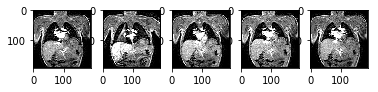

output result is below:


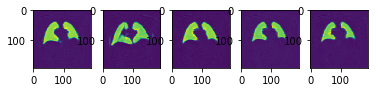

groundtruth result is below:


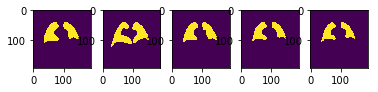

In [49]:
## testing train result
lungDataLoader = DataLoader(lung424, shuffle=True, batch_size=5)

dataiter = iter(lungDataLoader)

img, target = dataiter.next()

# print(img[i].cpu().numpy().dtype)

print(img.size(), target.size())

unet = torch.load('./unet.pkl')

out = unet(Variable(img.cuda()))
print(out.size())

print('input result is below:')
for i in range(5):
    position = 150 + i + 1
    plt.subplot(position)
    plt.imshow(np.transpose(img[i].cpu().numpy(), (1,2,0)))
plt.show()

print('output result is below:')
for i in range(5):
    position = 150 + i + 1
    plt.subplot(position)
    plt.imshow(np.transpose(np.squeeze(out[i].data.cpu().numpy(), axis=0), (0,1)))
plt.show()

print('groundtruth result is below:')
for i in range(5):
    position = 150 + i + 1
    plt.subplot(position)
    plt.imshow(np.transpose(np.squeeze(target[i].cpu().numpy(), axis=0), (0,1)))
plt.show()

In [4]:
## loading whole net model
#1. load both network structure and parameter
unet = torch.load('./unet.pkl')
print('loading unet whole model sucessfully !!!')

#2. load only the network parameter
unet.load_state_dict(torch.load('./unet_para.pkl'))
print('loading unet parameters sucessfully !!!')

loading unet whole model sucessfully !!!
loading unet parameters sucessfully !!!


(192, 192, 3) (192, 192, 3)


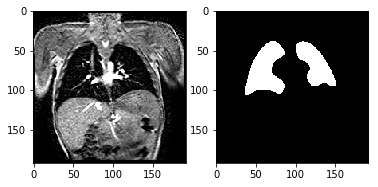

In [6]:
#show images
image, target = lung424.getRandItem()
print(image.shape, target.shape)

plt.figure(1)
plt.subplot(121)
plt.imshow(image)

plt.subplot(122)
plt.imshow(target*255)
plt.show()

In [26]:
## checkout network paremeters
# print(unet)  
  
# for param in unet.parameters():  
#     print('para type is {} and size is {}'.format(type(param.data), param.size()))
#     print('para list is {}'.format(list(param.data)))

## print out parameter keys
# print(unet.state_dict().keys())  

  
# for key in unet.state_dict():#模型参数  
#     print(key, 'corresponds to', list(unet.state_dict()[key]))

for m in unet.modules():
    print(m.__class__)

<class '__main__.UNET'>
<class 'torch.nn.modules.conv.Conv2d'>
<class 'torch.nn.modules.conv.Conv2d'>
<class 'torch.nn.modules.conv.Conv2d'>
<class 'torch.nn.modules.conv.Conv2d'>
<class 'torch.nn.modules.conv.Conv2d'>
<class 'torch.nn.modules.conv.Conv2d'>
<class 'torch.nn.modules.conv.Conv2d'>
<class 'torch.nn.modules.conv.Conv2d'>
<class 'torch.nn.modules.conv.Conv2d'>
<class 'torch.nn.modules.conv.Conv2d'>
<class 'torch.nn.modules.conv.Conv2d'>
<class 'torch.nn.modules.conv.Conv2d'>
<class 'torch.nn.modules.conv.Conv2d'>
<class 'torch.nn.modules.conv.Conv2d'>
<class 'torch.nn.modules.conv.Conv2d'>
<class 'torch.nn.modules.conv.Conv2d'>
<class 'torch.nn.modules.conv.Conv2d'>
<class 'torch.nn.modules.conv.Conv2d'>
<class 'torch.nn.modules.conv.Conv2d'>
<class 'torch.nn.modules.conv.Conv2d'>
<class 'torch.nn.modules.conv.Conv2d'>
<class 'torch.nn.modules.conv.Conv2d'>
<class 'torch.nn.modules.conv.Conv2d'>
<class 'torch.nn.modules.upsampling.UpsamplingBilinear2d'>


In [29]:
def grey2rgb(img):
    w, h = img.shape
    out = np.empty([3,w,h], dtype=np.float32)
    for i in range(3):
        out[i,:,:] = img
    return out